In [ ]:
# Start writing code here...

In [1]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from  sklearn.svm import SVR

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression



from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

import xgboost
from xgboost import XGBRegressor

from lib.viz import draw_histogram, create_silhoutte_cluster_viz
from lib.unsupervised import kmeans_parameters_search

from lib.supervised_tuning import FeatureTTRegressor, final_comparison, add_cluster_label, print_scores, predict_score_base_regressors, predict_mean_squared_error_regression

from matplotlib import pyplot as plt
from xgboost import plot_importance

%matplotlib inline


/shared-libs/python3.9/py/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
RANDOM_SEED = 42

## Load numpy arrays and dataframes from pickle files

In [3]:
with open('train_test_dict_standardscaler.pickle', 'rb') as file:
        train_test_dict = pickle.load( file)
X_train_impute = train_test_dict['X_train_impute']
X_test_impute = train_test_dict['X_test_impute']
y_train = train_test_dict['y_train']
y_test = train_test_dict['y_test']

with open('X_train_impute_standardscaler_df.pkl', 'rb') as file:
        X_train_impute_df = pickle.load( file)
with open('X_test_impute_standardscaler_df.pkl', 'rb') as file:
        X_test_impute_df = pickle.load( file)


array([[<AxesSubplot:title={'center':'TOTALDRILLDEPTH_AVG'}>,
        <AxesSubplot:title={'center':'WELLYIELD_AVG'}>,
        <AxesSubplot:title={'center':'STATICWATERLEVEL_AVG'}>,
        <AxesSubplot:title={'center':'TOPOFPERFORATEDINTERVAL_AVG'}>,
        <AxesSubplot:title={'center':'BOTTOMOFPERFORATEDINTERVAL_AVG'}>,
        <AxesSubplot:title={'center':'TOTALCOMPLETEDDEPTH_AVG'}>,
        <AxesSubplot:title={'center':'VEGETATION_BLUE_OAK-GRAY_PINE'}>,
        <AxesSubplot:title={'center':'VEGETATION_CALIFORNIA_COAST_LIVE_OAK'}>,
        <AxesSubplot:title={'center':'VEGETATION_CANYON_LIVE_OAK'}>],
       [<AxesSubplot:title={'center':'VEGETATION_HARD_CHAPARRAL'}>,
        <AxesSubplot:title={'center':'VEGETATION_KNOBCONE_PINE'}>,
        <AxesSubplot:title={'center':'VEGETATION_NON-NATIVE_HARDWOOD_FOREST'}>,
        <AxesSubplot:title={'center':'VEGETATION_PINYON-JUNIPER'}>,
        <AxesSubplot:title={'center':'SOIL_ALFISOLS_B'}>,
        <AxesSubplot:title={'center':'SOIL_ALFIS

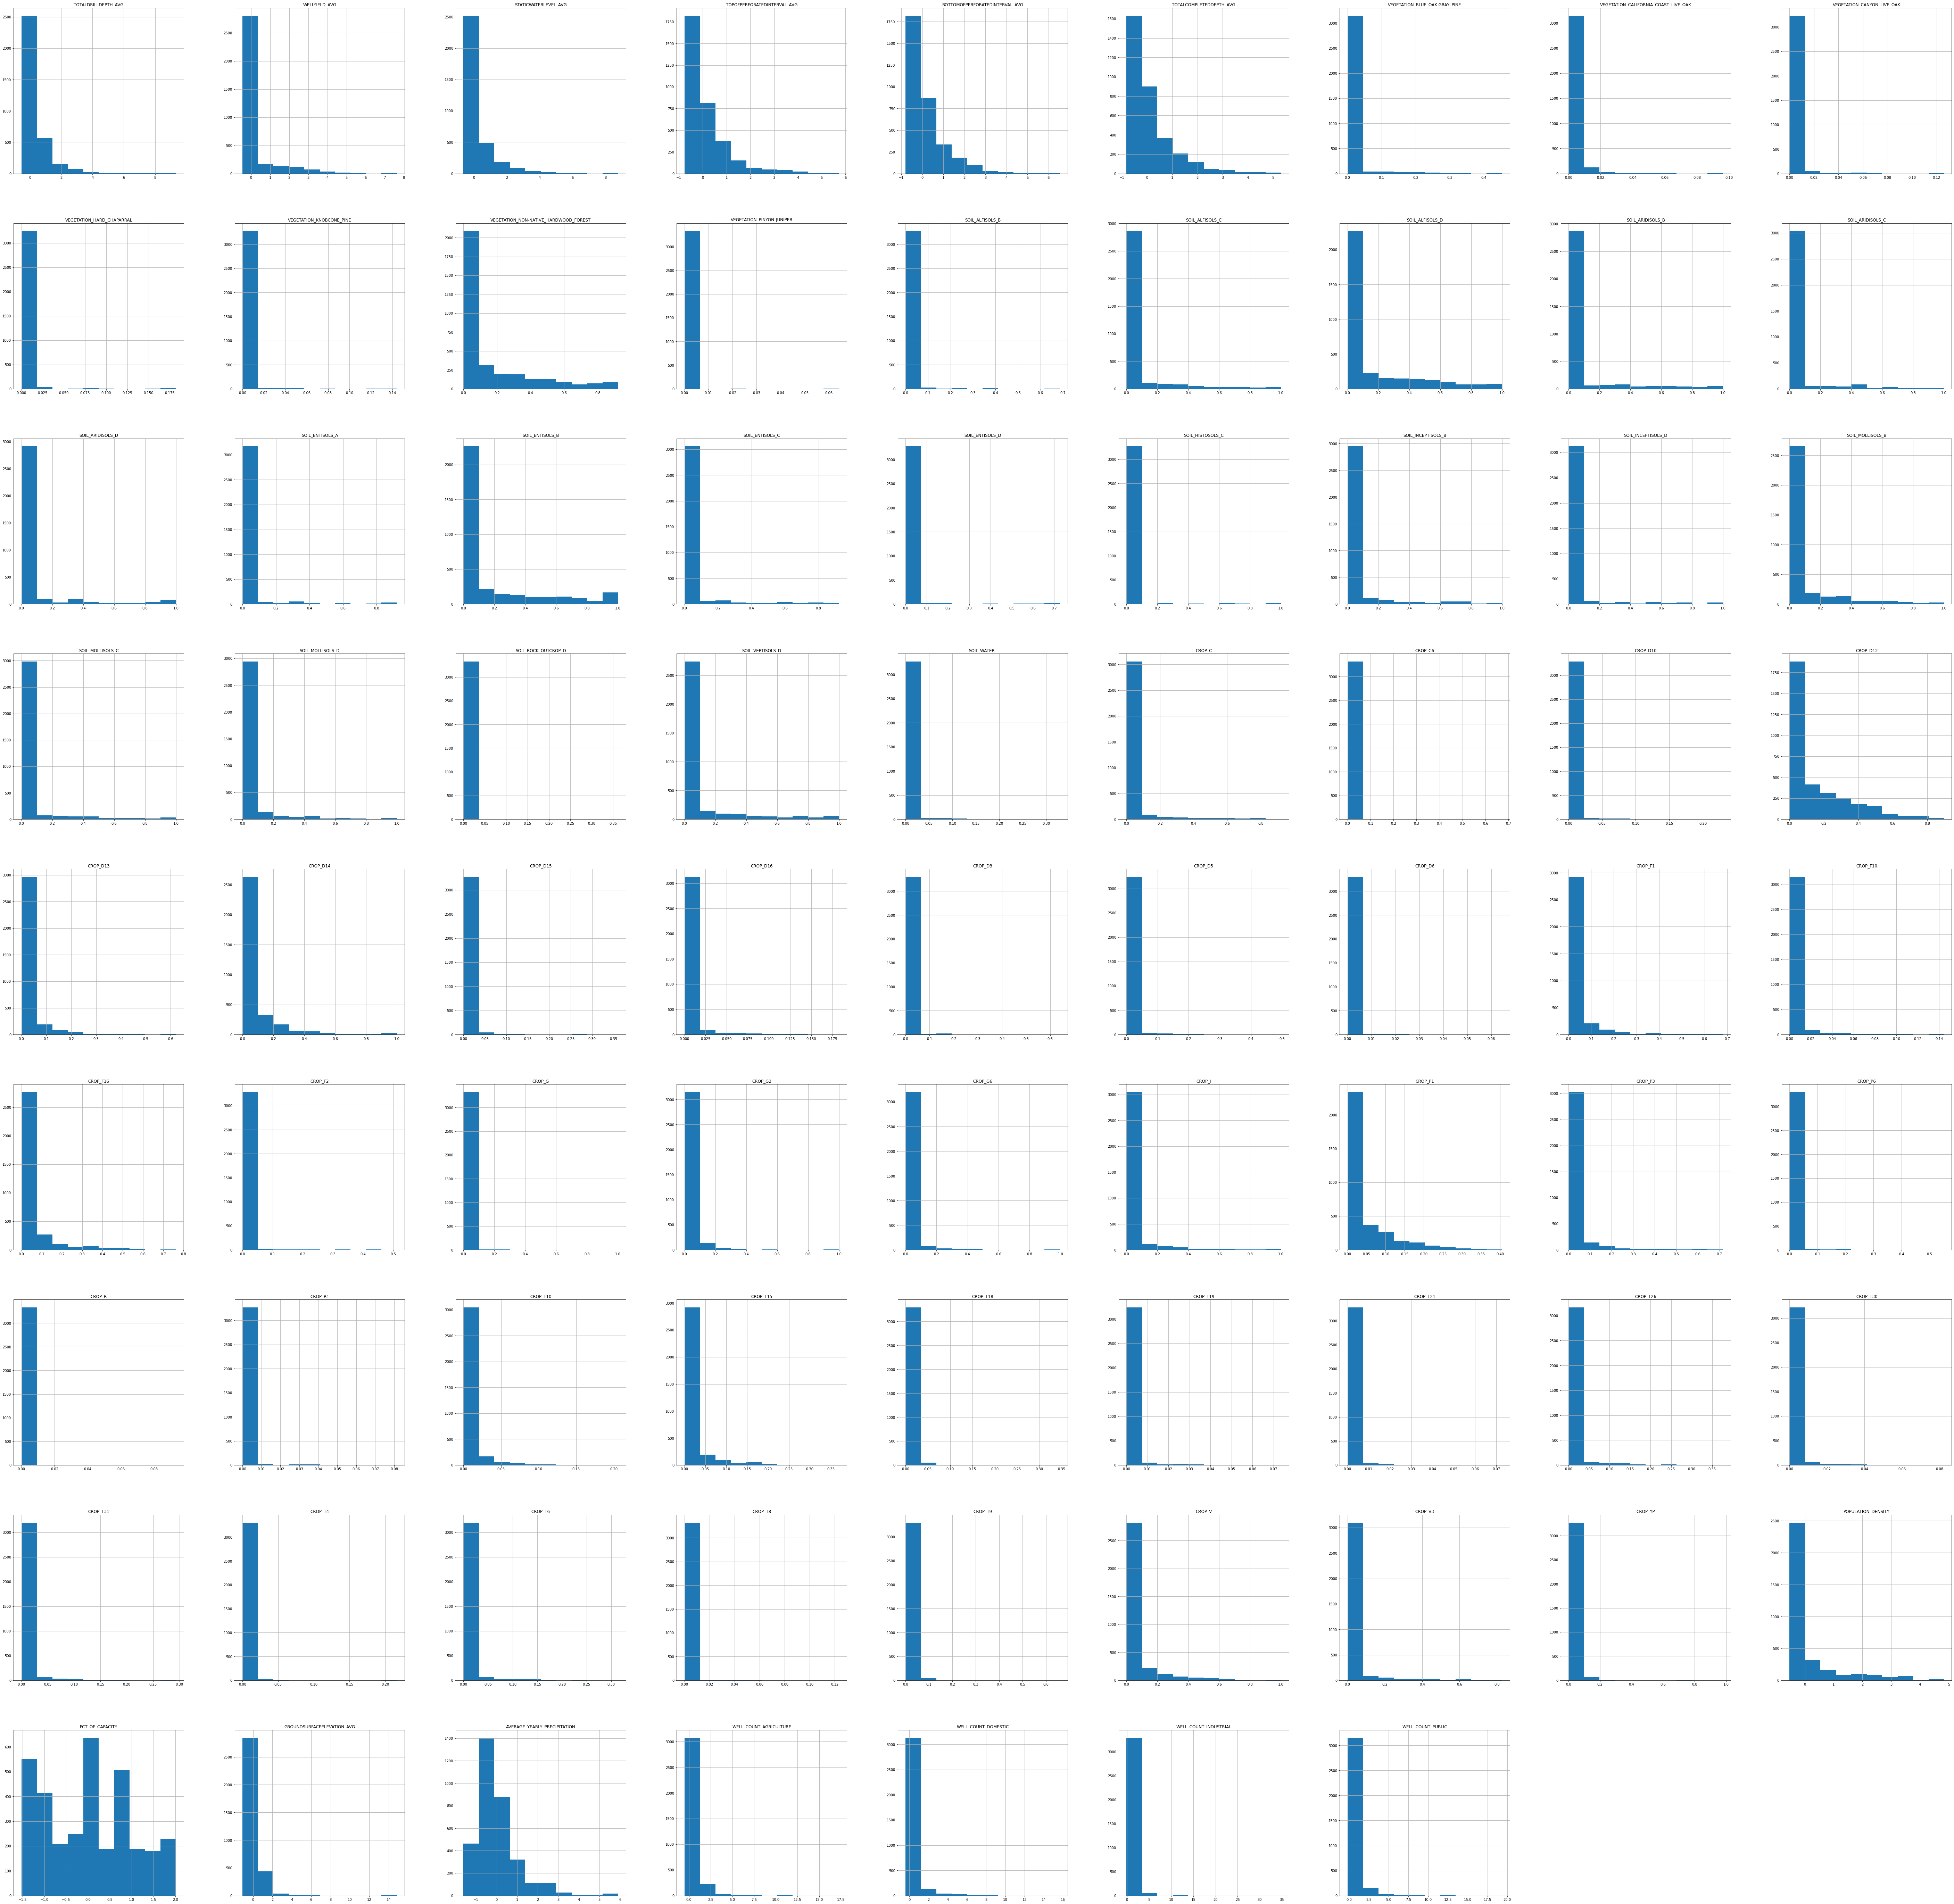

In [ ]:
X_train_impute_df.hist(figsize=(100, 100))

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

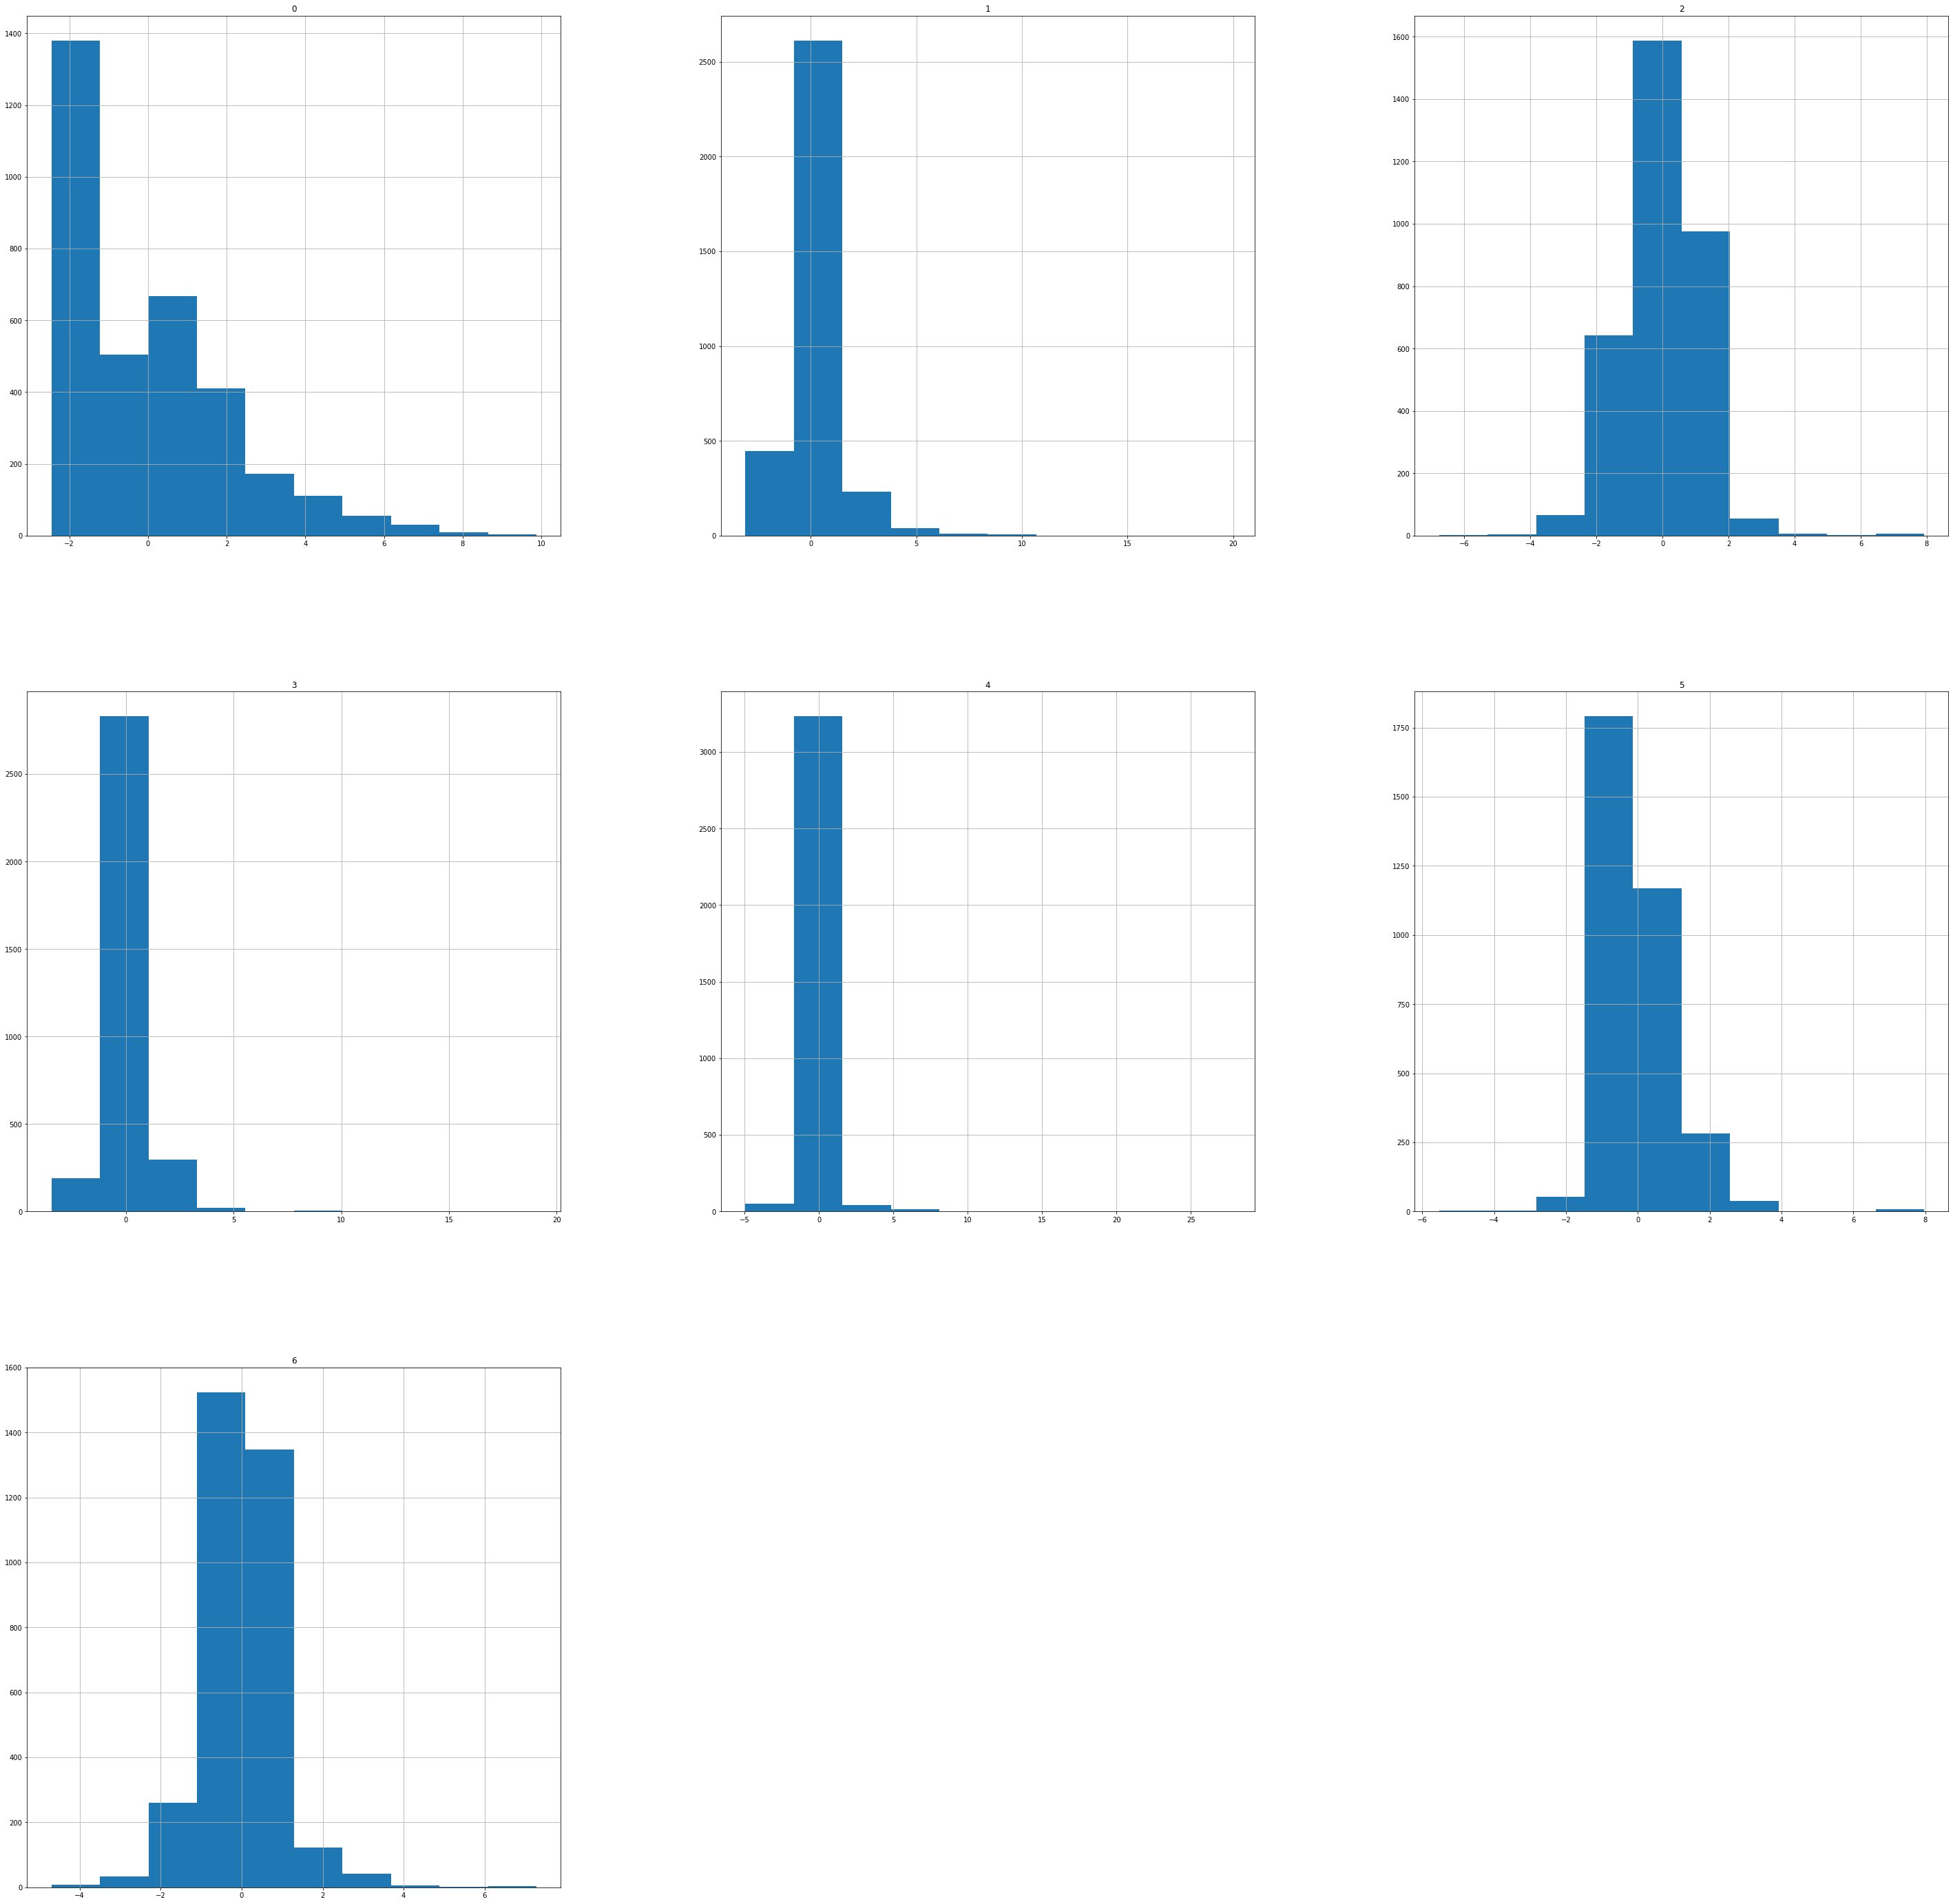

In [ ]:
pd.DataFrame(X_train_pca).hist(figsize=(50, 50))

## [Understand the distribution of the target](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

In [ ]:
draw_histogram(pd.DataFrame(y_train.reset_index()), "GSE_GWE" ) 

alt.LayerChart(...)

## [Normalize the target to improve accuracy](https://anshikaaxena.medium.com/how-skewed-data-can-skrew-your-linear-regression-model-accuracy-and-transfromation-can-help-62c6d3fe4c53)




In [ ]:
#We will view the variables with sqrt applied but we do not need these in the model since 
# we will be using TransformedTargetRegressor to wrap models to aid with Cross Validations
y_train_sqrt = np.sqrt(train_test_dict['y_train'])
y_test_sqrt = np.sqrt(train_test_dict['y_test'])
draw_histogram(pd.DataFrame(y_train_sqrt.reset_index()), "GSE_GWE" ) 

alt.LayerChart(...)

### Baseline
   - Distribution of the target and statistics such as mean and median 
   - It can be observed below that the target has a [left skewed distribution](https://stats.stackexchange.com/questions/11351/left-skewed-vs-symmetric-distribution-observed/11352#11352) with most well of the groundwater depth less that 200
   - The score of this regressor is very low : R-squared of the prediction = -0.057
   - The r-squared isnegative and this indicates that the the sum-of-squares of the residuals from the model (SSres) is larger than the sum-of-squares from the horizontal line (median) (SStot).
   - R-squared is computed as 1−SSres/SStot. (here, SSres = residual error)When SSres is greater than SStot, that equation could compute a negative value for R-squared, if the value of the coefficient is greater than 1.

## Unnormalized data dummy score

In [ ]:
regressor_dict = {"Dummy Regressor": DummyRegressor(strategy="median"),
                 "Linear Regressor" : LinearRegression(),
                 "Ridge Regressor" : Ridge(),
                 "Lasso Regressor": Lasso()
}

for reg_name in regressor_dict.keys():
    model = regressor_dict[reg_name].fit(X_train_impute, y_train)
    predict_mean_squared_error_regression(model, X_train_impute, y_train, reg_name)


Prediction from Dummy Regressor is : [135.47275 135.47275 135.47275 ... 135.47275 135.47275 135.47275]
Scores from Dummy Regressor : R2 score:-0.057090827770692965;  MSE score:17442.601081718243; RMSE score:132.07043984828036
Prediction from Linear Regressor is : [124.02559817 111.4254949   97.06014597 ... 324.66703306 320.78229306
 320.82513735]
Scores from Linear Regressor : R2 score:0.5595387697659555;  MSE score:7267.861312483043; RMSE score:85.25175254786873
Prediction from Ridge Regressor is : [122.36096044 106.85415893  97.9512874  ... 315.23472464 310.35964295
 309.11776963]
Scores from Ridge Regressor : R2 score:0.5116318808253719;  MSE score:8058.352281569421; RMSE score:89.7683256030178
Prediction from Lasso Regressor is : [100.4447834   83.95961512  79.61023103 ... 223.31467851 215.08817061
 214.40654012]
Scores from Lasso Regressor : R2 score:0.3775917065499912;  MSE score:10270.091545015785; RMSE score:101.34146014842979


## Normalized data dummy score

In [ ]:
regressor_dict = {"Dummy Regressor": DummyRegressor(strategy="median"),
                 "Linear Regressor" : LinearRegression(),
                 "Ridge Regressor" : Ridge(),
                 "Lasso Regressor": Lasso()
}

for reg_name in regressor_dict.keys():
    tt = TransformedTargetRegressor(regressor=regressor_dict[reg_name],
                                 func=np.sqrt, inverse_func=np.square)
    model = tt.fit(X_train_impute, y_train)
    predict_mean_squared_error_regression(model, X_train_impute, y_train, reg_name)


Prediction from Dummy Regressor is : [135.47274744 135.47274744 135.47274744 ... 135.47274744 135.47274744
 135.47274744]
Scores from Dummy Regressor : R2 score:-0.057090837296556174;  MSE score:17442.601238900417; RMSE score:132.07044044334984
Prediction from Linear Regressor is : [ 98.29491802  88.32982673  78.47149348 ... 300.01063979 292.37559662
 293.80798655]
Scores from Linear Regressor : R2 score:0.5304705250291626;  MSE score:7747.503916287395; RMSE score:88.01990636377316
Prediction from Ridge Regressor is : [ 98.17196078  86.22652802  79.11057919 ... 274.39468129 265.50511794
 265.38634628]
Scores from Ridge Regressor : R2 score:0.47227218088433665;  MSE score:8707.809761221806; RMSE score:93.31564585438932
Prediction from Lasso Regressor is : [131.32910489 125.89763637 123.69779341 ... 134.6222196  133.03446142
 133.08355273]
Scores from Lasso Regressor : R2 score:0.0735218007177868;  MSE score:15287.418277073364; RMSE score:123.64229970796146


## Using Unsupervised Learning to instrument feature to improve Supervised Learning

- Both Silhouette score (closer to 1 is better) and  davies_bouldin_score (lower is better) emphasize the distance between clusters 
- intertia tries to minimize the distane from point to center (lower is better) 
- For this dataset the davies_bouldin_score as well as inertia drops with the rise in number of clusters but silhouette score is higher at k=2

In [ ]:
# Assume the number of clusters
kmeans_score_df = kmeans_parameters_search(X_train_impute, random_seed= RANDOM_SEED)
print (f"Top clustering Scores : {kmeans_score_df.loc[0]}")

Top clustering Scores : k                              2.000000
davies_bouldin_score           1.797506
calinski_harabasz_score      804.008961
silhouette_score               0.271402
inertia                    39708.596250
Name: 0, dtype: float64


## [Silhouette Score Visualization](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as)
1.  near +1 indicate that the sample is far away from the neighboring clusters. 
2. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and 
3. negative values indicate that **those samples might have been assigned to the wrong cluster.**
4. Also from the thickness of the silhouette plot the cluster size can be visualized. 

For n_clusters = 2 The average silhouette_score is : 0.27140214446988076
For n_clusters = 3 The average silhouette_score is : 0.2168357132262969
For n_clusters = 4 The average silhouette_score is : 0.20460163319979777
For n_clusters = 5 The average silhouette_score is : 0.2117219104592868
For n_clusters = 6 The average silhouette_score is : 0.22374932500859115


<module 'matplotlib.pyplot' from '/shared-libs/python3.9/py/lib/python3.9/site-packages/matplotlib/pyplot.py'>

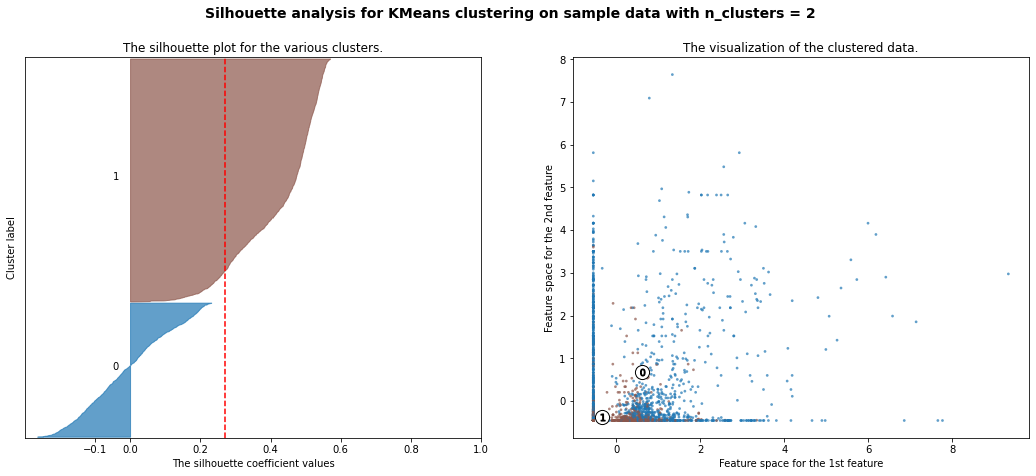

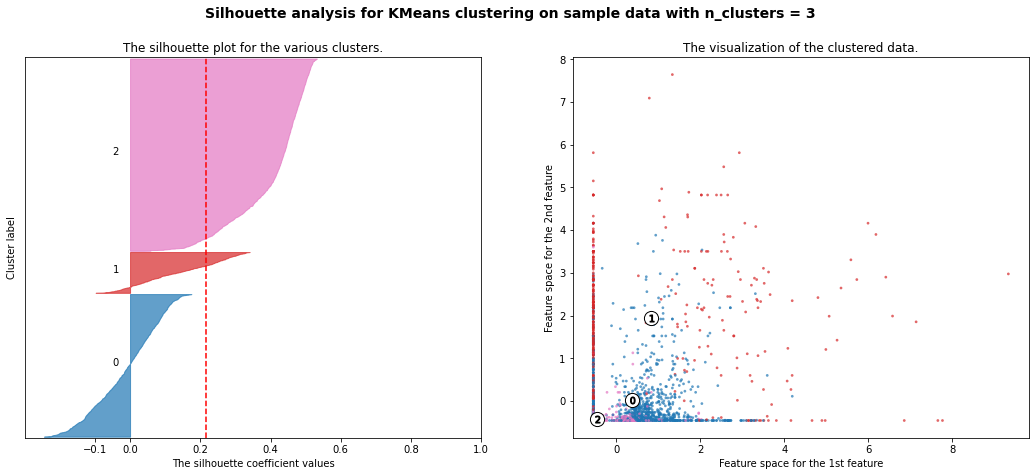

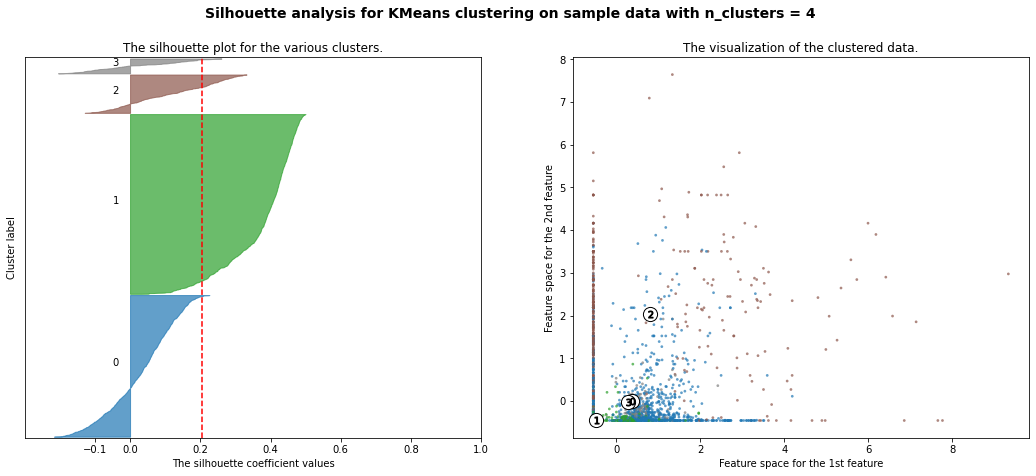

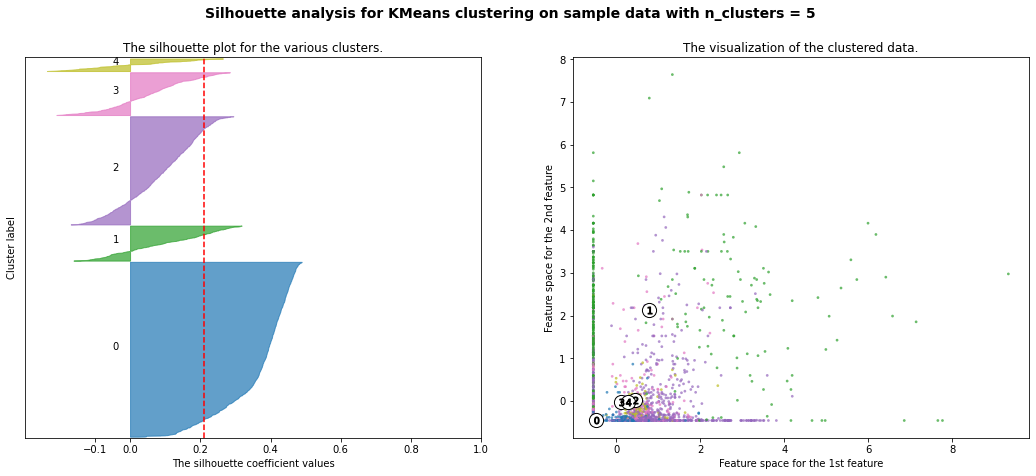

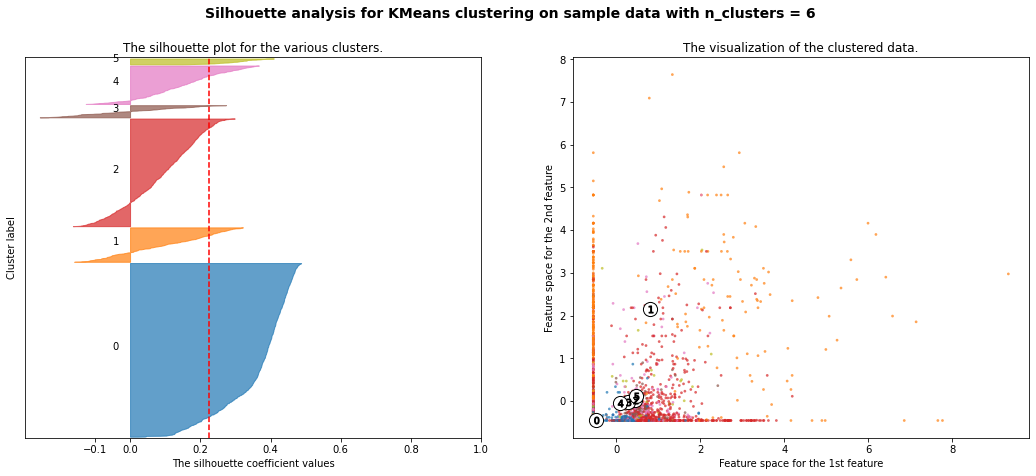

In [ ]:
create_silhoutte_cluster_viz(X_train_impute, RANDOM_SEED)

### Observations from clustering scores and visualizations

1. The scores indicate that 2 or 3 clusters will provide the best scores. The Silhouette score is low ~0.22 
2. The visualization show that the second cluster onwards, the data points are so scattered that they may have been incorrectly assigned  into a cluster.This causes the score to be negative and so we see negative scores for clusters more than 1.
3. The clusters are not evenly sized (thickness along Y-axis)
4. Our dataset has one main cluster and the other clusters are not definitive. This might be because we have taken into account data from only teh agricultural San Joaquin valley in California. If our dataset included a larger geogrpahy, say all of California, it is likely our clusters would be ore defined.


### Observations from clustering on the training set

1. The clusters do not include all years of a township range. There is no pattern as to which Township-Range and years are included in a cluster





## Adding KMeans clustering label as feature

### Random searching to narrow down possibilities to provide to GridSearch

Regularization and Generalization for [Lasso](https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression)

When it comes to training models, there are two major problems one can encounter: overfitting and underfitting.

- Overfitting happens when the model performs well on the training set but not so well on unseen (test) data.
- Underfitting happens when it neither performs well on the train set nor on the test set.
Particularly, regularization is implemented to avoid overfitting of the data, especially when there is a large variance between train and test set performances. With regularization, the number of features used in training is kept constant, yet the magnitude of the coefficients is reduced.


**Ridge and Lasso** 

**Lasso Regression for Model Selection**
Lasso is short for Least Absolute Shrinkage and Selection Operator, which is used both for regularization and model selection. If a model uses the L1 regularization technique, then it is called lasso regression. 
Due to the fact that coefficients will be shrunk towards a mean of zero, less important features in a dataset are eliminated when penalized. The shrinkage of these coefficients based on the alpha value provided leads to some form of automatic feature selection, as input variables are removed in an effective approach.

**Ridge regression** puts a similar constraint on the coefficients by introducing a penalty factor. However, while lasso regression takes the magnitude of the coefficients, ridge regression takes the square.
Minimizes objective function:
||y - Xw||^2_2 + alpha * ||w||^2_2


**Scores**
[Negative Mean Absolute Error](https://stackoverflow.com/questions/55786121/what-is-the-negative-mean-absolute-error-in-scikit-learn#:~:text=As%20its%20name%20implies%2C%20negative,than%20a%20value%20of%20%2D3.0%20.) Smaller the better

## 

## Unnormalized RandomForest

In [ ]:
rfreg = RandomForestRegressor(
    max_depth=7, n_estimators=200, random_state=RANDOM_SEED
).fit(X_train_impute, y_train)
print(f"Train set score: {rfreg.score(X_train_impute, y_train)}")
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py
print(
    f"Test set score:{rfreg.score(X_test_impute, y_test)}"
)  # without duration = -0.601225986040484


Train set score: 0.7925083604008445
Test set score:-0.4010759418041887


## Normalized RandomForest

In [ ]:
rfreg = RandomForestRegressor(
    max_depth=7, n_estimators=200, random_state=RANDOM_SEED
)
tt = TransformedTargetRegressor(regressor=rfreg, func=np.sqrt, inverse_func=np.square).fit(X_train_impute, y_train)

print_scores(tt, X_train_impute, y_train, "Random Forest")
print_scores(tt, X_test_impute, y_test, "Random Forest")


Scores from Random Forest : R2 score:0.7508820275347046;  MSE score:4110.588515049726; RMSE score:64.11387147138852
Scores from Random Forest : R2 score:-0.3234015143801863;  MSE score:22189.19023413299; RMSE score:148.9603646415146


## Normalized Linear Regression

In [ ]:

# random search linear regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.model_selection import RepeatedKFold


model = TransformedTargetRegressor(regressor=Lasso(), func=np.sqrt, inverse_func=np.square)
#print(model.get_params().keys())

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
# define search space
space = dict()

space["regressor__alpha"] =  [ 1,0.1,0.01,0.001,0.0001]    #loguniform(1e-5, 100)
space["regressor__fit_intercept"] = [True, False]
# define search
search = RandomizedSearchCV(
    model,
    space,
    n_iter= 100,  #500,
    scoring= 'r2',    #"neg_median_absolute_error",‘neg_root_mean_squared_error’
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_SEED,
)
# execute search
train_result = search.fit(X_train_impute, y_train)
# summarize result
print("Best Score: %s" % train_result.best_score_)
print("Best Hyperparameters: %s" % train_result.best_params_)

#Best Score: 0.5044823845848624
#Best Hyperparameters: {'regressor__fit_intercept': True, 'regressor__alpha': 0.0001}


/root/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Best Score: 0.5044823845848624
Best Hyperparameters: {'regressor__fit_intercept': True, 'regressor__alpha': 0.0001}


### Support Vector Machine Regressor

- We will be choosing the parameters first in this case and then run the regression with chosen parameters

In [ ]:
## Commenting out code since the best parameters have been found
# param_grid = [
#     {
#         "C": [0.5, 1, 10, 100],
#         "gamma": ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
#         "kernel": ["linear", "rbf"],
#     }
# ]

# optimal_params = GridSearchCV(
#     SVR(),
#     param_grid,
#     cv=5,
#     scoring='r2',
#     verbose=0
# )
# optimal_params.fit(X_train_impute, y_train_sqrt)
# print(optimal_params.best_params_)

#Unnormalized{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
#Normalized{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

## Unnormalized SVM

In [ ]:
svmreg = SVR(C= 100, gamma= 0.01, kernel= 'rbf')
svmreg.fit(X_train_impute, y_train)
print_scores (svmreg, X_train_impute, y_train, "Unnormalized SVM")
print_scores (svmreg, X_test_impute, y_test, "Unnormalized SVM")


#Training Score : 0.4618833343933596
#Testing Score : 0.15005476507505444

Scores from Unnormalized SVM : R2 score:0.4618833343933596;  MSE score:8879.231648803097; RMSE score:94.22967499043546
Scores from Unnormalized SVM : R2 score:0.15005476507505444;  MSE score:14250.850026552484; RMSE score:119.3769241794765


## Normalized SVM

In [ ]:
svmreg = SVR(C=1, gamma= 'scale', kernel= 'rbf')
tt = TransformedTargetRegressor(regressor=svmreg, func=np.sqrt, inverse_func=np.square).fit(X_train_impute, y_train)
print_scores (tt, X_train_impute, y_train, "Train Set Normalized SVM")
print_scores (tt, X_test_impute, y_test, "Test Set Normalized SVM")


Scores from Train Set Normalized SVM : R2 score:0.5262434268542211;  MSE score:7817.253445146953; RMSE score:88.41523310576608
Scores from Test Set Normalized SVM : R2 score:0.16311826320549183;  MSE score:14031.817146515863; RMSE score:118.45597134174311


## SVM on the PCA data with normalized target

In [ ]:
## Commenting out code since the best parameters have been found
tt = TransformedTargetRegressor(regressor=SVR(), func=np.sqrt, inverse_func=np.square )
param_grid = [
    {
        'regressor__C': [0.5, 1, 10, 100],
        'regressor__gamma': ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
        "regressor__kernel": ["linear", "rbf"],
    }
]

optimal_params = GridSearchCV(
    tt,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=0
)
optimal_params.fit(X_train_pca, y_train)
print(optimal_params.best_params_)

#{'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}

{'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}


In [ ]:
svmreg = SVR(C=10, gamma= 'scale', kernel= 'rbf')
tt = TransformedTargetRegressor(regressor=svmreg,
                                 func=np.sqrt,
                                 inverse_func=np.square).fit(X_train_pca, y_train)
print_scores (tt, X_train_pca, y_train, "Train Set Normalized SVM")
print_scores (tt, X_test_pca, y_test, "Test Set Normalized SVM")


Scores from Train Set Normalized SVM : R2 score:0.4602638991747733;  MSE score:8905.953252806661; RMSE score:94.3713582227503
Scores from Test Set Normalized SVM : R2 score:0.13411669044888208;  MSE score:14518.080316077716; RMSE score:120.4909968258115


#### SVR comparison between normalized and unnormalized target

The R-squared training score improved by 14% and MSE dropped by 12%

## Unnormalized with cluster feature

In [ ]:
# 14 clusters (best davies_bouldin_score) gives a marginally better train score than 2 clusters  and same score for test set
X_train_cluster_df, X_test_cluster_df = add_cluster_label(
    X_train_impute_df, X_test_impute_df, n_clusters=2, random_seed=RANDOM_SEED
)

In [ ]:
svmreg = SVR(C=100, gamma=0.01, kernel="rbf")
svmreg.fit(X_train_cluster_df.values, y_train)
print(f"Training Score : {svmreg.score(X_train_cluster_df.values, y_train)}")
print(f"Testing Score : {svmreg.score(X_test_cluster_df, y_test)}")


Training Score : 0.46539749919575946
Testing Score : 0.16007759552109269


## Normalized with cluster feature

In [ ]:
svmreg = SVR(C=1, gamma='scale', kernel="rbf")

tt = TransformedTargetRegressor(regressor=svmreg, func=np.sqrt, inverse_func=np.square).fit(X_train_cluster_df.values, y_train)

print_scores (tt, X_train_cluster_df, y_train, "Training Normalized SVM")
print_scores (tt, X_test_cluster_df, y_test, "Testing Normalized SVM")


Scores from Training Normalized SVM : R2 score:0.5237917077059593;  MSE score:7857.708208298882; RMSE score:88.6437149960384
Scores from Testing Normalized SVM : R2 score:0.16841857208061117;  MSE score:13942.94800086979; RMSE score:118.08026084350335


## Install and test with XGBoost

[Example](https://deepnote.com/@salamituns/Simple-implemention-of-xgboost-fbb18b95-40b7-4bd7-836a-f5335c49bb84)

##### The XGBoost library has its own custom API, although we will use the method via the scikit-learn wrapper classes: XGBRegressor 

Two or more regression models created using a given sample of data can be compared based on their MSE. The lesser the MSE, the better the regression model is. When the linear regression model is trained using a given set of observations, the model with the least mean sum of squares error (MSE) is selected as the best model. The Python or R packages select the best-fit model as the model with the lowest MSE or lowest RMSE when training the linear regression models.

The value of MSE is always positive. A value close to zero will represent better quality of the estimator/predictor (regression model).

In [ ]:
# create an xgboost regression model

model = TransformedTargetRegressor(regressor=XGBRegressor(), func=np.sqrt, inverse_func=np.square).fit(X_train_impute, y_train)

model = model.fit(X_train_impute, y_train)
print_scores (model, X_train_impute, y_train, "Training Normalized SVM")
print_scores (model, X_test_impute, y_test, "Testing Normalized SVM")


Scores from Training Normalized SVM : R2 score:0.9863935643744349;  MSE score:224.51394196780822; RMSE score:14.983789306040318
Scores from Testing Normalized SVM : R2 score:-0.5823196153429495;  MSE score:26530.41467350048; RMSE score:162.8815970989371


### Observations
The training scores have radically improved but the testing scores are quite miserable and so we 
will hypetune parameters

## [Hyperparameter tuning for XGBoost](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d)

In [ ]:
#https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d
#https://stats.stackexchange.com/questions/243908/tuning-order-xgboost

#xgb_objective - The default squared error loss function will be used for regression 

# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(50, 250, 5)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 5)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 5)]

# Tree construction algorithm used in XGBoost
#xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']
xgb_tree_method = ['auto', 'exact']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [1.0, 2.0]

#Lambda has ore effect on tree pruning than gamma which is a threshold for gain
xgb_lambda =[ 1.0, 5.0, 10.0, 50.0, 100.0]


xgb_fit_params  = {'eval_metric': 'rmse',
                   'eval_set': [(X_train_impute, y_train), (X_test_impute, y_test)],
                  }

# Create the grid
xgb_grid = {'regressor__n_estimators': xgb_n_estimators,
            'regressor__max_depth': xgb_max_depth,
            'regressor__min_child_weight': xgb_min_child_weight,
            'regressor__tree_method': xgb_tree_method,
            'regressor__learning_rate': xgb_eta,
            'regressor__gamma': xgb_gamma,
            'regressor__reg_lambda' : xgb_lambda}




In [ ]:
xgb_grid

{'regressor__n_estimators': [50, 100, 150, 200, 250],
 'regressor__max_depth': [2, 6, 11, 15, 20],
 'regressor__min_child_weight': [1, 3, 5, 7, 10],
 'regressor__tree_method': ['auto', 'exact'],
 'regressor__learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6],
 'regressor__gamma': [1.0, 2.0],
 'regressor__reg_lambda': [1.0, 5.0, 10.0, 50.0, 100.0]}

In [ ]:
xgb_base = XGBRegressor()
xgb_base = TransformedTargetRegressor(regressor=xgb_base, func=np.sqrt, inverse_func=np.square)
#xgb_base.get_params().keys()

# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid,
                                n_iter = 50, cv = 3, verbose = 1, 
                                random_state = RANDOM_SEED, n_jobs = -1)


# Fit the random search model
xgb_random.fit(X_train_impute, y_train, **xgb_fit_params)

# Get the optimal parameters
xgb_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:206.84312	validation_1-rmse:214.99879
[1]	validation_0-rmse:204.85748	validation_1-rmse:212.90311
[2]	validation_0-rmse:203.41888	validation_1-rmse:211.38975
[3]	validation_0-rmse:202.35544	validation_1-rmse:210.11216
[4]	validation_0-rmse:201.62517	validation_1-rmse:209.39196
[5]	validation_0-rmse:201.05222	validation_1-rmse:208.77363
[6]	validation_0-rmse:200.64537	validation_1-rmse:208.36786
[7]	validation_0-rmse:200.32036	validation_1-rmse:208.08344
[8]	validation_0-rmse:200.09846	validation_1-rmse:207.85304
[9]	validation_0-rmse:199.89710	validation_1-rmse:207.61545
[10]	validation_0-rmse:199.74250	validation_1-rmse:207.49317
/root/venv/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
[11]	validation_0-rmse:199.60310	valida

{'regressor__tree_method': 'auto',
 'regressor__reg_lambda': 100.0,
 'regressor__n_estimators': 50,
 'regressor__min_child_weight': 3,
 'regressor__max_depth': 2,
 'regressor__learning_rate': 0.30000000000000004,
 'regressor__gamma': 1.0}

In [ ]:
#gamma = 0 No pruning will occur


## Add an alpha
xgb_final = XGBRegressor(tree_method = 'auto',
                         #objective = 'reg:squarederror',
                         n_estimators = 50,
                         min_child_weight=3,
                         max_depth=2,
                         gamma=1,
                         eta=0.30000000000000004,
                         reg_lambda=100.0,
                         random_state = RANDOM_SEED)

xgb_final = FeatureTTRegressor(regressor=xgb_final, func=np.sqrt, inverse_func=np.square)                        

xgb_final = xgb_final.fit(X_train_impute, y_train)
print_scores (xgb_final, X_train_impute, y_train, "Training XGBoost")
print_scores (xgb_final, X_test_impute, y_test, "Testing XGBoost")

#Scores from Training XGBoost : R2 score:0.6884415352643526;  MSE score:5140.892221605126; RMSE score:71.70001549236322
#Scores from Testing XGBoost : R2 score:-0.22694363390112082;  MSE score:20571.901575872944; RMSE score:143.4290820436111762054039927

Scores from Training XGBoost : R2 score:0.6884415352643526;  MSE score:5140.892221605126; RMSE score:71.70001549236322
Scores from Testing XGBoost : R2 score:-0.22694363390112082;  MSE score:20571.901575872944; RMSE score:143.42908204361117


In [ ]:
import altair as alt
color_for_bars = '#6e0a1e'
feature_imp_dict = pd.DataFrame({"Feature Number": range(len(xgb_final.feature_importances_)), 
              "Feature Name":list(X_train_impute_df.columns),
              "Feature Importance": xgb_final.feature_importances_
})
(alt.Chart(feature_imp_dict
).mark_bar(color=color_for_bars
).encode(
    x=alt.X("Feature Name:N", sort='-y'),
    y="Feature Importance:Q"
)
)


alt.Chart(...)

[Crop to Code mapping](https://github.com/mlnrt/milestone2_waterwells_data/blob/main/crops/crop_name_to_type_mapping.json)

## Try XGBoost with PCA componenets and standard scaling

In [ ]:
#Check for all columns mean and standard deviation
X_train_impute[:, 1].std()

1.0

In [ ]:
xgb_final = XGBRegressor(tree_method = 'auto',
                         #objective = 'reg:squarederror',
                         n_estimators = 50,
                         min_child_weight=3,
                         max_depth=2,
                         gamma=1,
                         eta=0.30000000000000004,
                         reg_lambda=100.0,
                         random_state = RANDOM_SEED)

xgb_final = FeatureTTRegressor(regressor=xgb_final, func=np.sqrt, inverse_func=np.square)                        

xgb_final = xgb_final.fit(X_train_impute, y_train)
print_scores (xgb_final, X_train_impute, y_train, "Training XGBoost")
print_scores (xgb_final, X_test_impute, y_test, "Testing XGBoost")

Scores from Training XGBoost : R2 score:0.6884415352643526;  MSE score:5140.892221605126; RMSE score:71.70001549236322
Scores from Testing XGBoost : R2 score:-0.22694363390112082;  MSE score:20571.901575872944; RMSE score:143.42908204361117


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
params = {'n_neighbors':[20, 20, 50, 100, 300]}

knn = KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train_cluster_df,y_train_sqrt)
model.best_params_
#Unnormalized{'n_neighbors': 20}

{'n_neighbors': 20}

## Unnormalized with cluster feature

In [ ]:
knnreg = KNeighborsRegressor(n_neighbors=20)
knnreg.fit(X_train_cluster_df, y_train)
print (f"Training Score : {knnreg.score(X_train_cluster_df, y_train)}")
print (f"Testing Score : {knnreg.score(X_test_cluster_df, y_test)}")

Training Score : 0.6542233147780179
Testing Score : 0.030631193713440696


## Unnormalized with cluster feature

In [ ]:
knnreg = KNeighborsRegressor(n_neighbors=20)
knnreg.fit(X_train_cluster_df, y_train_sqrt)
print (f"Training Score : {knnreg.score(X_train_cluster_df, y_train_sqrt)}")
print (f"Testing Score : {knnreg.score(X_test_cluster_df, y_test_sqrt)}")

Training Score : 0.6752069268790966
Testing Score : 0.06623210643960076


#Ideas
1. Drop features such as vegetation and crops and soil
2. Add K Means clustering results

### PyCaret Experimentations

In [ ]:
!pip install pycaret[full] 
#Restart kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 KB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 KB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 KB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [4]:
#This might need restart of the kernel
from pycaret.regression import *

In [5]:
train_data = pd.concat([X_train_impute_df, y_train], axis=1)
test_data = pd.concat([X_test_impute_df, y_test], axis=1)


array([[<AxesSubplot:title={'center':'TOTALDRILLDEPTH_AVG'}>,
        <AxesSubplot:title={'center':'WELLYIELD_AVG'}>,
        <AxesSubplot:title={'center':'STATICWATERLEVEL_AVG'}>,
        <AxesSubplot:title={'center':'TOPOFPERFORATEDINTERVAL_AVG'}>,
        <AxesSubplot:title={'center':'BOTTOMOFPERFORATEDINTERVAL_AVG'}>,
        <AxesSubplot:title={'center':'TOTALCOMPLETEDDEPTH_AVG'}>,
        <AxesSubplot:title={'center':'VEGETATION_BLUE_OAK-GRAY_PINE'}>,
        <AxesSubplot:title={'center':'VEGETATION_CALIFORNIA_COAST_LIVE_OAK'}>,
        <AxesSubplot:title={'center':'VEGETATION_CANYON_LIVE_OAK'}>],
       [<AxesSubplot:title={'center':'VEGETATION_HARD_CHAPARRAL'}>,
        <AxesSubplot:title={'center':'VEGETATION_KNOBCONE_PINE'}>,
        <AxesSubplot:title={'center':'VEGETATION_NON-NATIVE_HARDWOOD_FOREST'}>,
        <AxesSubplot:title={'center':'VEGETATION_PINYON-JUNIPER'}>,
        <AxesSubplot:title={'center':'SOIL_ALFISOLS_B'}>,
        <AxesSubplot:title={'center':'SOIL_ALFIS

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


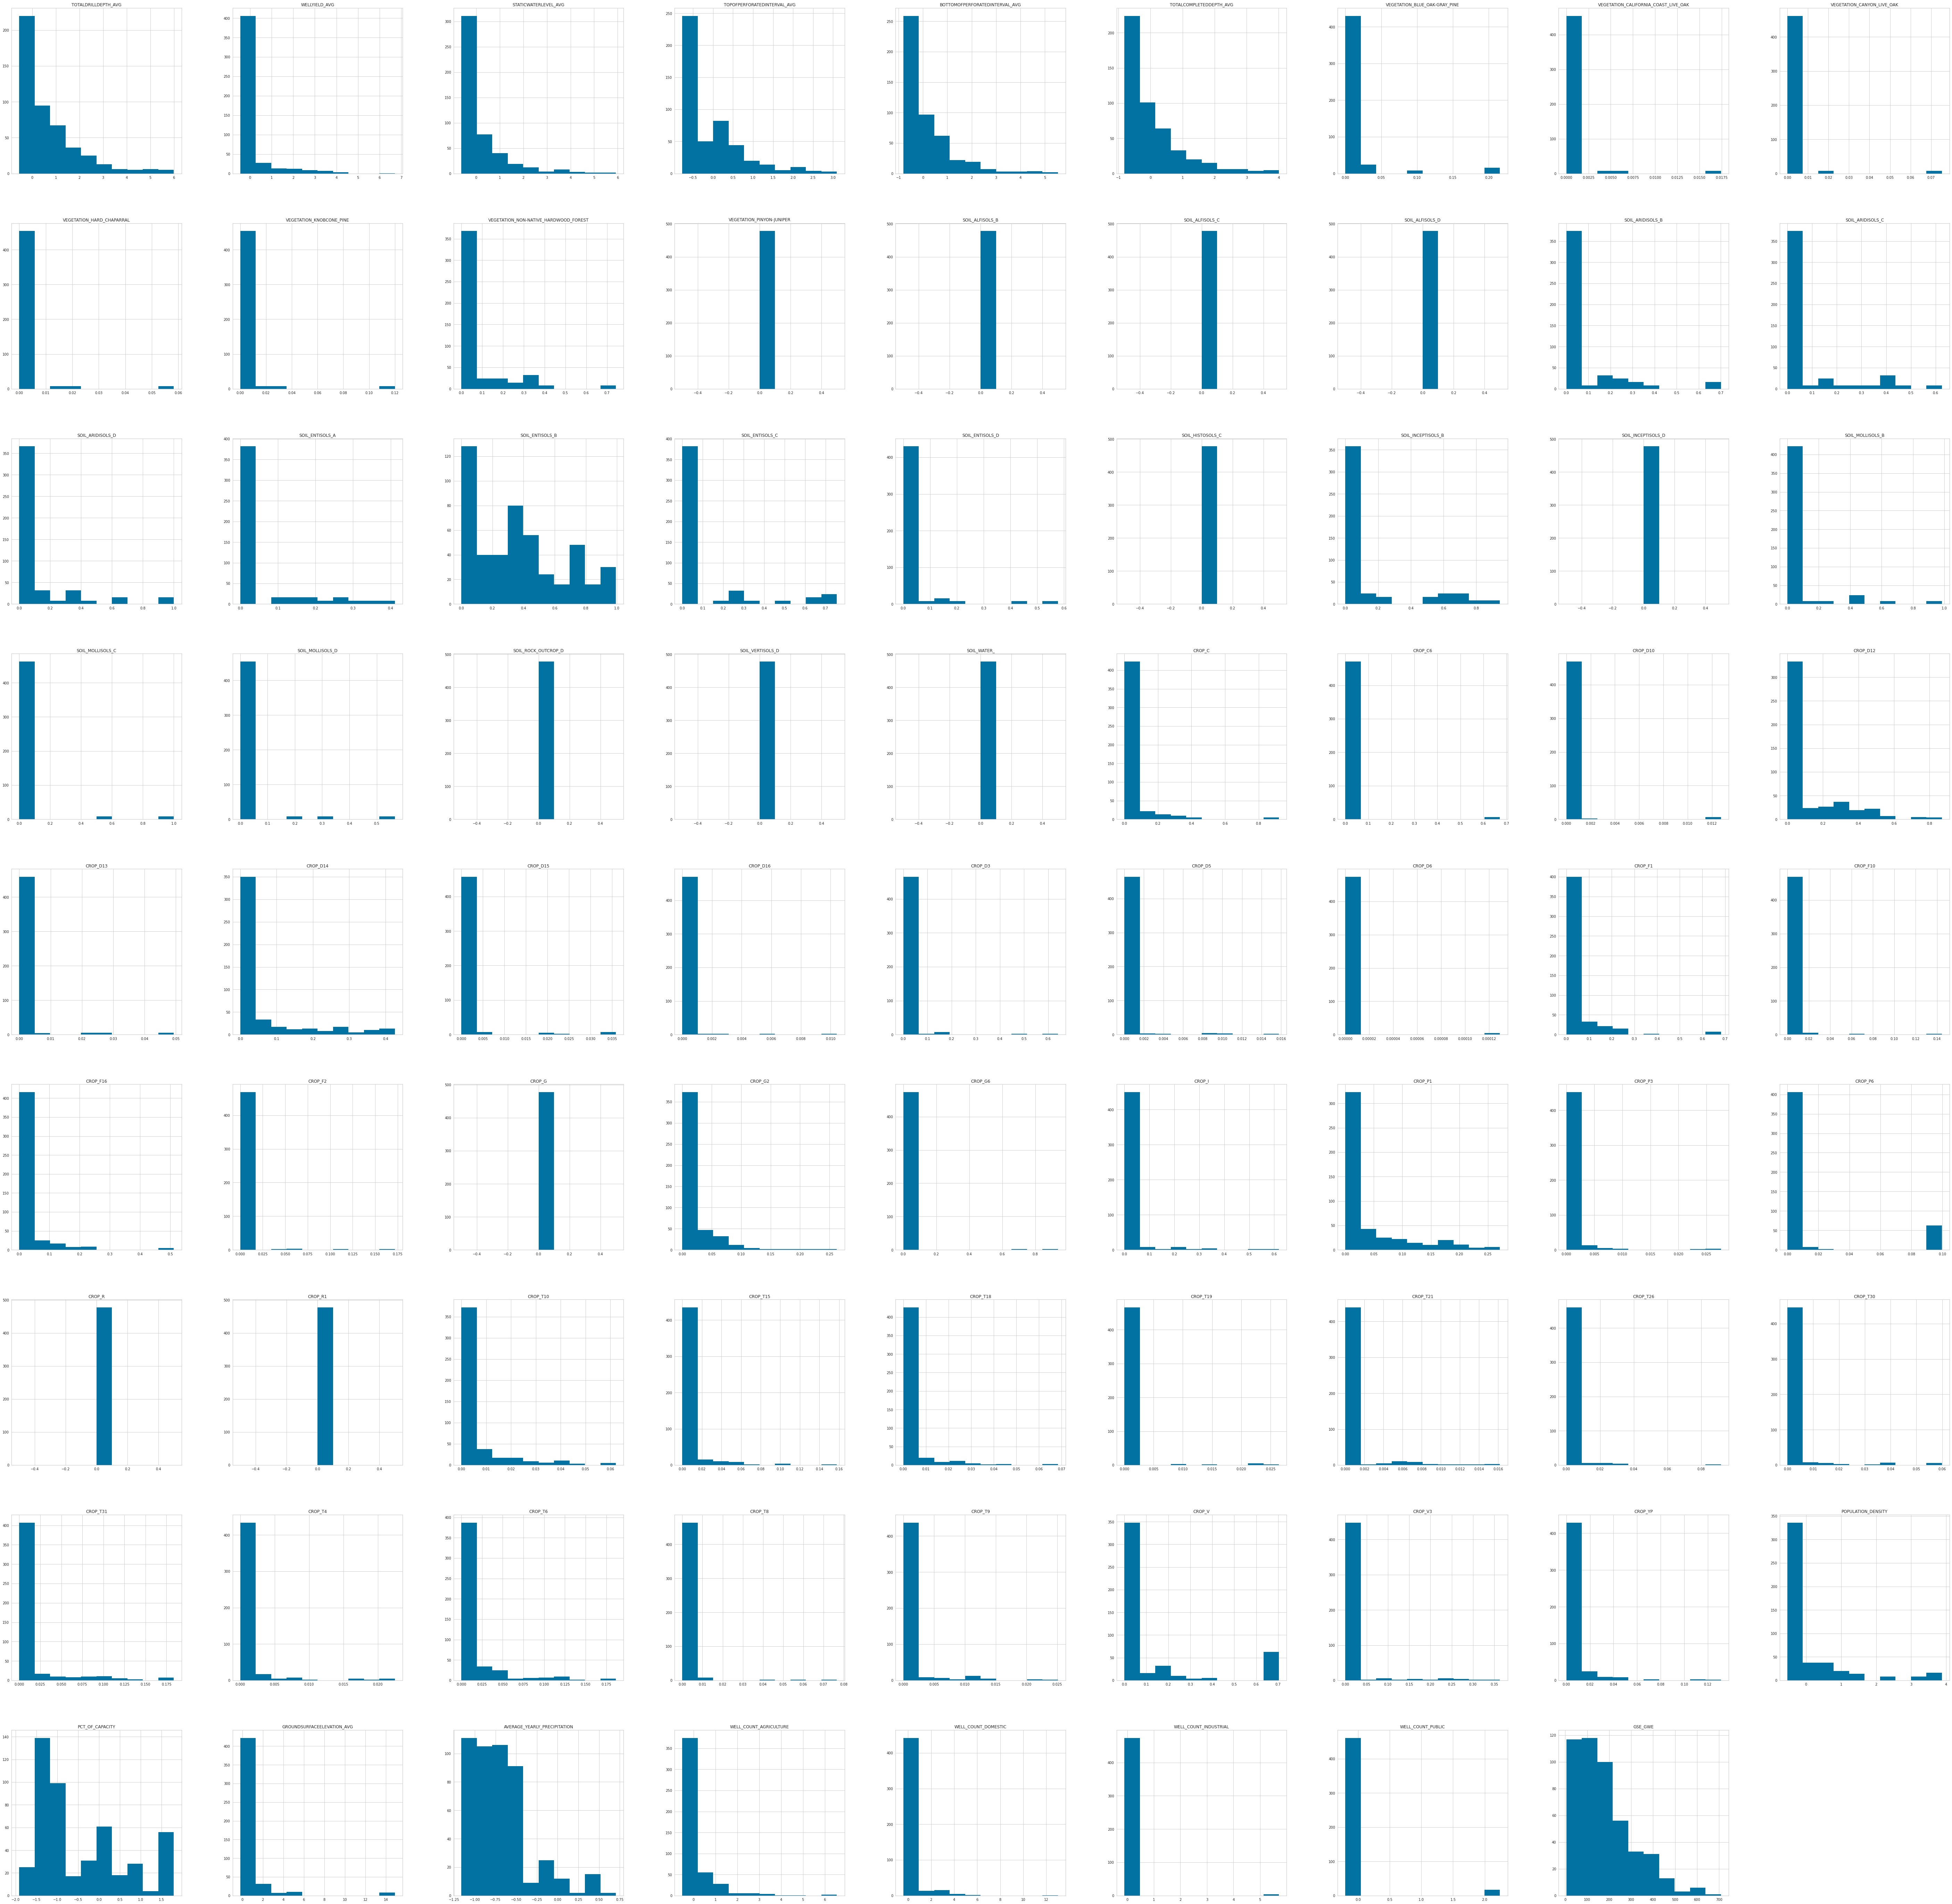

In [6]:
test_data.hist(figsize=(100,100))

#### PyCaret experiments with PCA, target transformations, low variance

### Use PCA components to train

- Component 0: ['TOTALCOMPLETEDDEPTH_AVG', 'BOTTOMOFPERFORATEDINTERVAL_AVG', 'TOPOFPERFORATEDINTERVAL_AVG', 'STATICWATERLEVEL_AVG']: well_water_depth
- Component 1: ['WELL_COUNT_DOMESTIC', 'WELL_COUNT_PUBLIC', 'WELL_COUNT_AGRICULTURE', - 'POPULATION_DENSITY'] well_usage_population
- Component 2: ['PCT_OF_CAPACITY', 'AVERAGE_YEARLY_PRECIPITATION', 'GROUNDSURFACEELEVATION_AVG', 'WELL_COUNT_AGRICULTURE'] precipitation_collection_elevation
- Component 3: ['GROUNDSURFACEELEVATION_AVG', 'WELL_COUNT_INDUSTRIAL', 'AVERAGE_YEARLY_PRECIPITATION', 'POPULATION_DENSITY'] elevation_industrial_usage_population
- Component 4: ['WELL_COUNT_INDUSTRIAL', 'AVERAGE_YEARLY_PRECIPITATION', 'POPULATION_DENSITY', 'WELL_COUNT_AGRICULTURE'] elevation_agricultural_usage_population
- Component 5: ['POPULATION_DENSITY', 'GROUNDSURFACEELEVATION_AVG', 'TOTALDRILLDEPTH_AVG', 'WELL_COUNT_AGRICULTURE'] populattion_elevation_well_feature_agriculture
- Component 6: ['TOTALDRILLDEPTH_AVG', 'WELLYIELD_AVG', 'STATICWATERLEVEL_AVG', 'GROUNDSURFACEELEVATION_AVG'] well_details_elevation

In [7]:
with open("X_pca_standardscaler.pickle", "rb") as file:
    pca_train_test_dict = pickle.load(file)
X_train_standardscaler_pca = pca_train_test_dict["X_train_pca"]
X_test_standardscaler_pca = pca_train_test_dict["X_test_pca"]

arr_train_y = y_train.values.reshape(y_train.values.shape[0], 1)
arr_test_y = y_test.values.reshape(y_test.values.shape[0], 1)

pca_train_standardscaler_df = pd.DataFrame(
    np.hstack((X_train_standardscaler_pca, arr_train_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "Component_6",
        "GSE_GWE",
    ],
)
pca_test_standardscaler_df = pd.DataFrame(
    np.hstack((X_test_standardscaler_pca, arr_test_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "Component_6",
        "GSE_GWE",
    ],
)


In [8]:
target_normalized_exp = setup(
    pca_train_standardscaler_df,
    target="GSE_GWE",
    preprocess=False,
    #Transform the target
    transform_target= True,
    train_size=1.0,
    test_data=pca_test_standardscaler_df,
    session_id=RANDOM_SEED,
    log_experiment=True,
    pca=True,
    pca_components=7,
    pca_method="linear",
    experiment_name="water_depth_pca_standardscaler"
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 8)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,0
6,Transformed Train Set,"(3346, 7)"
7,Transformed Test Set,"(478, 7)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/07/04 14:36:42 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_pca_standardscaler' does not exist. Creating a new experiment.


In [9]:
pca_standardscaler_best = compare_models(['et', 'rf'],fold=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,69.2732,10285.1542,96.8231,0.0826,0.7236,1.0042,1.4900
rf,Random Forest Regressor,71.3887,10794.3259,99.1640,0.0427,0.7381,1.0443,2.0933


In [12]:
with open("X_pca_minmax.pickle", "rb") as file:
    pca_train_test_dict = pickle.load(file)
X_train_minmax_pca = pca_train_test_dict["X_train_pca"]
X_test_minmax_pca = pca_train_test_dict["X_test_pca"]

arr_train_y = y_train.values.reshape(y_train.values.shape[0], 1)
arr_test_y = y_test.values.reshape(y_test.values.shape[0], 1)

pca_train_minmax_df = pd.DataFrame(
    np.hstack((X_train_minmax_pca, arr_train_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "Component_6",
        "Component_7",
        "Component_8",
        "Component_9",
        "Component_10",
        "Component_11",
        "GSE_GWE",
    ],
)
pca_test_minmax_df = pd.DataFrame(
    np.hstack((X_test_minmax_pca, arr_test_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "Component_6",
        "Component_7",
        "Component_8",
        "Component_9",
        "Component_10",
        "Component_11",
        "GSE_GWE",
    ],
)


In [13]:
target_normalized_exp = setup(
    pca_train_minmax_df,
    target="GSE_GWE",
    preprocess=False,
    #Transform the target
    transform_target= True,
    train_size=1.0,
    test_data=pca_test_minmax_df,
    session_id=RANDOM_SEED,
    log_experiment=True,
    pca=True,
    pca_components=7,
    pca_method="linear",
    experiment_name="water_depth_pca_minmax"
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Transformed Train Set,"(3346, 12)"
7,Transformed Test Set,"(478, 12)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/07/04 14:41:29 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_pca_minmax' does not exist. Creating a new experiment.


In [14]:
pca_minmax_best = compare_models(['et', 'rf'])


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,81.1472,13822.1424,109.1983,-0.1457,0.8341,1.3663,1.2900
rf,Random Forest Regressor,84.0826,14668.2850,112.6982,-0.1779,0.8457,1.4404,3.0290


#### Run PyCaret experiment  by ignoring low variance and remove multi-collinearity

In [15]:
from pycaret.regression import *

# We already have an imputed and scaled train and test, we do not want to preprocess

target_normalized_exp = setup(
    train_data,
    target="GSE_GWE",
    preprocess=False,
    #Transform the target
    transform_target= True,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.1,
    #Low Variance in feature
    ignore_low_variance=True,
    train_size=1.0,
    test_data=test_data,
    session_id=RANDOM_SEED,
    log_experiment=True,
    experiment_name="water_depth_1",
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,79
5,Categorical Features,0
6,Transformed Train Set,"(3346, 79)"
7,Transformed Test Set,"(478, 79)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [16]:
#get_config('X_train').columns

In [17]:
#get_config('X_train')

In [18]:
best = compare_models(['et', 'knn', 'lightgbm', 'xgboost', 'ada', 'rf', 'gbr'], fold=51)
#et	Extra Trees Regressor	49.8439	6499.0555	68.1167	0.4340	0.5374	0.6717	3.8614

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,49.8439,6499.0555,68.1167,0.4340,0.5374,0.6717,4.3392
lightgbm,Light Gradient Boosting Machine,51.8857,6934.4174,71.5961,0.3372,0.5580,0.7313,0.7647
rf,Random Forest Regressor,54.5155,7834.7322,75.8803,0.2621,0.5951,0.8116,7.2494
xgboost,Extreme Gradient Boosting,54.8537,7441.8539,74.7684,0.2491,0.5981,0.8183,2.4788
gbr,Gradient Boosting Regressor,60.2911,8477.5304,79.9440,0.1805,0.6219,0.8965,2.4384
knn,K Neighbors Regressor,60.5709,8886.6683,83.4694,0.0630,0.6478,0.8320,0.0937
ada,AdaBoost Regressor,75.5638,11354.2206,93.9477,-0.0632,0.7167,1.0716,0.8125


In [19]:
print(best)

PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             

In [ ]:
model = create_model(best, fold=51)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


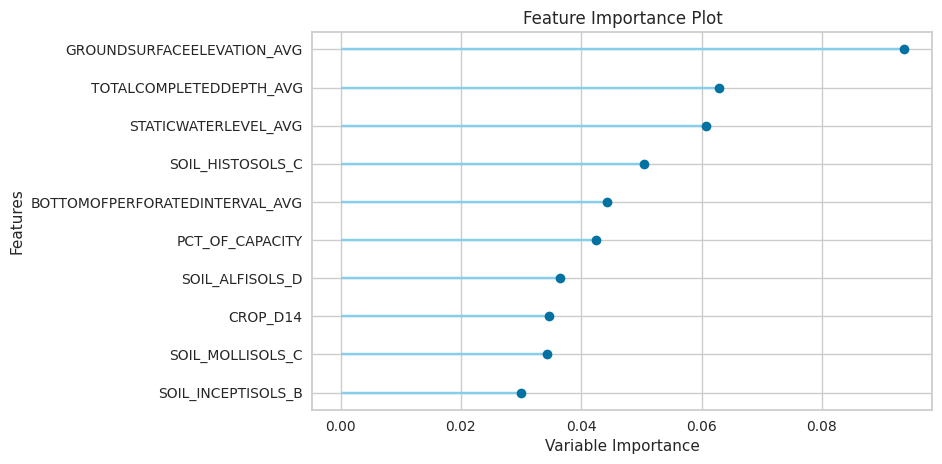

In [20]:
plot_model(best, plot='feature')

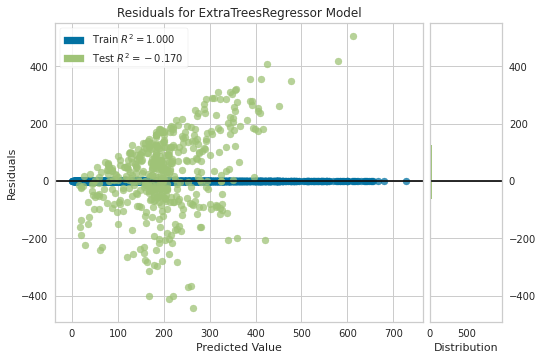

In [21]:
plot_model(best, plot='residuals') 

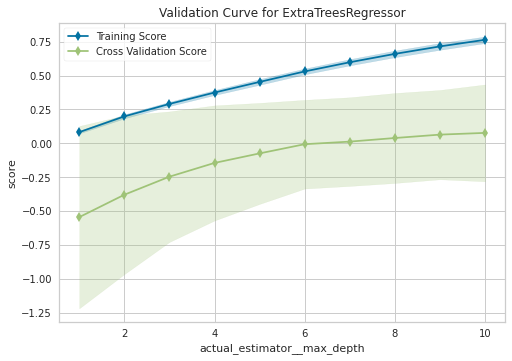

In [22]:
plot_model(best, plot='vc') 

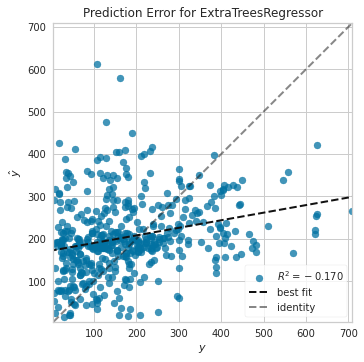

In [23]:
plot_model(best, plot='error') 

In [24]:
model_name = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,45.7295,4084.9639,63.9137,-0.8335,1.0503,2.3446
1,28.9203,1383.1845,37.1912,0.5906,0.5546,0.6597
2,37.2004,2167.5592,46.5571,0.3989,0.8267,1.4633
3,97.9519,22576.9414,150.2563,0.0432,0.9572,0.9038
4,70.0809,8215.5752,90.6398,0.3787,1.0046,3.5092
5,67.9977,13424.2184,115.8629,0.2700,0.6081,0.5670
6,52.3749,7412.7068,86.0971,0.5435,0.3940,0.3068
7,71.7532,8964.3045,94.6800,-0.1050,0.4815,0.3902
8,125.1126,27960.4275,167.2137,0.0041,0.7289,0.7467


In [25]:
tuned_model_name = tune_model(model_name)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.1252,3786.0595,61.5310,-0.6993,1.1641,2.7178
1,36.3713,1923.1941,43.8542,0.4307,0.7574,1.2309
2,47.4433,3216.6472,56.7155,0.1080,0.9467,1.8302
3,115.2447,25996.9804,161.2358,-0.1017,0.9794,1.1897
4,75.6913,9701.5088,98.4962,0.2664,0.9569,2.7852
5,87.8344,15763.0517,125.5510,0.1428,0.6975,0.7529
6,77.7787,13442.0065,115.9397,0.1723,0.5666,0.4759
7,79.0764,10069.0930,100.3449,-0.2412,0.4814,0.3545
8,145.8502,35744.5546,189.0623,-0.2731,0.8344,0.8750


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


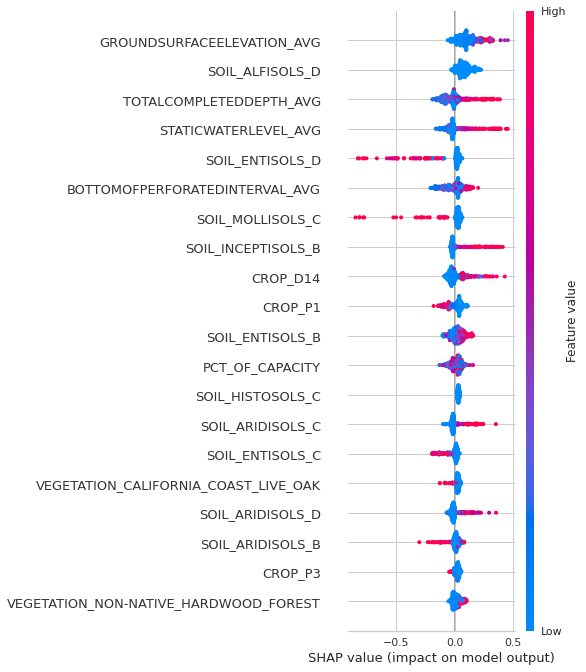

In [26]:
#Since the tuned model is not as good as the best, going with the best
interpret_model(best)

### Improve above model with feature interactions

In [27]:
# We already have an imputed and scaled train and test, we do not want to preprocess
#https://pycaret.gitbook.io/docs/get-started/preprocessing/feature-engineering
feature_interaction_exp = setup(
    train_data,
    target="GSE_GWE",
    preprocess=False,
    #Transform the target
    transform_target= True,
    train_size=1.0,
    test_data=test_data,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.001,
    remove_perfect_collinearity= True,
    #Low Variance in feature
    ignore_low_variance=True,
    session_id=RANDOM_SEED,
    polynomial_features = True,
    polynomial_degree = 3,
    polynomial_threshold = 0.05,
    log_experiment=True,
    experiment_name="water_depth_feature_engg_5",
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,79
5,Categorical Features,0
6,Transformed Train Set,"(3346, 79)"
7,Transformed Test Set,"(478, 79)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/07/04 15:26:59 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_feature_engg_5' does not exist. Creating a new experiment.


In [28]:
feature_engg_best = compare_models(['et', 'knn', 'lightgbm', 'xgboost', 'rf', 'gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,67.5045,10850.3303,96.3378,0.1173,0.7355,1.1668,4.4970
knn,K Neighbors Regressor,71.7248,11571.7238,101.5740,0.0165,0.7769,1.1707,0.1950
lightgbm,Light Gradient Boosting Machine,70.9867,12083.3810,102.9223,-0.0044,0.7489,1.3617,0.6510
gbr,Gradient Boosting Regressor,74.6296,12478.4339,103.9782,-0.0141,0.7662,1.3041,2.1740
rf,Random Forest Regressor,71.4509,11687.9602,102.0104,-0.0549,0.7679,1.2489,6.6330
xgboost,Extreme Gradient Boosting,76.7390,13168.7916,107.7094,-0.1504,0.7936,1.3719,2.4140


### Group Features

In [ ]:
# We already have an imputed and scaled train and test, we do not want to preprocess
#https://pycaret.gitbook.io/docs/get-started/preprocessing/feature-engineering
group_feature_exp = setup(
    train_data,
    target="GSE_GWE",
    preprocess=False,
    #Transform the target
    transform_target= True,
    remove_multicollinearity = True,
    
    multicollinearity_threshold=0.05,
    #Low Variance in feature
    ignore_low_variance=True,
    train_size=1.0,
    test_data=test_data,
    session_id=RANDOM_SEED,
    group_features = ['TOTALCOMPLETEDDEPTH_AVG', 'TOTALDRILLDEPTH_AVG',
                         'BOTTOMOFPERFORATEDINTERVAL_AVG', 'TOPOFPERFORATEDINTERVAL_AVG',
                         'STATICWATERLEVEL_AVG'],
                   
    log_experiment=True,
    experiment_name="water_depth_group_features_1",
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,79
5,Categorical Features,0
6,Transformed Train Set,"(3346, 79)"
7,Transformed Test Set,"(478, 79)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/07/04 02:58:16 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_group_features_1' does not exist. Creating a new experiment.


In [ ]:
group_feature_best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,67.5045,10850.3303,96.3378,0.1173,0.7355,1.1668,3.2680
catboost,CatBoost Regressor,67.4060,10753.7434,96.8806,0.0991,0.7108,1.1594,16.5960
knn,K Neighbors Regressor,71.7248,11571.7238,101.5740,0.0165,0.7769,1.1707,0.4170
lightgbm,Light Gradient Boosting Machine,70.9867,12083.3810,102.9223,-0.0044,0.7489,1.3617,0.4320
gbr,Gradient Boosting Regressor,74.6296,12478.4339,103.9782,-0.0141,0.7662,1.3041,1.7530
rf,Random Forest Regressor,71.4509,11687.9602,102.0104,-0.0549,0.7679,1.2489,5.1020
ada,AdaBoost Regressor,83.7396,13767.6181,109.5120,-0.1172,0.8169,1.3349,0.4140
xgboost,Extreme Gradient Boosting,76.7390,13168.7916,107.7094,-0.1504,0.7936,1.3719,1.4180
lasso,Lasso Regression,101.8036,18554.2255,130.4438,-0.7687,0.9795,1.8308,0.2840
en,Elastic Net,101.8036,18554.2255,130.4438,-0.7687,0.9795,1.8308,0.0240


#### Ignore features by selecting only those indicated as important in the last training

In [33]:
ignore_cols_list = [col for col in train_data.columns if col not in 
                        ('GROUNDSURFACEELEVATION_AVG'
                        ,'TOTALCOMPLETEDDEPTH_AVG'
                        ,'STATICWATERLEVEL_AVG'
                        ,'SOIL_HISTOSOLS_C'
                        ,'BOTTOMOFPERFORATEDINTERVAL_AVG'
                        ,'PCT_OF_CAPACITY'
                        ,'SOIL_ALFISOLS_D'
                        ,'CROP_D14'
                        # ,'CROP_P1'
                        # ,'CROP_P3'
                        # ,'CROP_D12'
                        # ,'SOIL_MOLLISOLS_C'
                        # ,'SOIL_INCEPTISOLS_B'
                        # ,'VEGETATION_CALIFORNIA_COAST_LIVE_OAK'
                        # ,'SOIL_ENTISOLS_B'
                        # ,'SOIL_ENTISOLS_C'
                        # ,'SOIL_ENTISOLS_D'
                        # ,'SOIL_ARIDISOLS_C'
                        # ,'VEGETATION_NON-NATIVE_HARDWOOD_FOREST'
                        , 'POPULATION_DENSITY'
                        , 'GSE_GWE')
]

In [34]:
# We already have an imputed and scaled train and test, we do not want to preprocess
chosen_cols_target_normalized_exp = setup(
    train_data,
    target="GSE_GWE",
    preprocess=False,
    #Transform the target
    transform_target= True,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.1,
    #Low Variance in feature
    ignore_low_variance=True,
    train_size=1.0,
    test_data=test_data,
    session_id=RANDOM_SEED,
    log_experiment=True,
    ignore_features=ignore_cols_list,
    experiment_name="water_depth_chosen_cols",
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Transformed Train Set,"(3346, 9)"
7,Transformed Test Set,"(478, 9)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [36]:
selected_cols_best = compare_models(['et', 'knn', 'lightgbm', 'xgboost', 'ada', 'rf', 'gbr'], fold=51)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,57.1266,8227.0465,79.8602,0.1450,0.5932,0.7854,0.1937
gbr,Gradient Boosting Regressor,61.3103,8673.6284,82.3248,0.1215,0.6194,0.8858,0.6116
et,Extra Trees Regressor,55.0342,8636.9503,80.1209,0.0940,0.5617,0.7417,0.9469
rf,Random Forest Regressor,58.1632,9006.3207,82.7840,0.0152,0.5996,0.8051,1.6431
xgboost,Extreme Gradient Boosting,58.3168,8583.7201,81.9874,-0.0151,0.6077,0.7888,0.7459
ada,AdaBoost Regressor,75.2029,11460.1046,94.5694,-0.0863,0.7178,1.0540,0.1488
knn,K Neighbors Regressor,69.7259,12959.3695,101.3648,-0.5839,0.7135,1.0367,0.0371


## Voting Ensemble

In [38]:
lightgbm= create_model('lightgbm', verbose=False)
gbr= create_model('gbr', verbose=False)

blender= blend_models([lightgbm, gbr])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,30.7396,2209.5461,47.0058,0.0083,0.6848,0.8787
1,36.7618,2420.4670,49.1982,0.2835,0.6936,1.0020
2,40.3809,3478.0399,58.9749,0.0355,0.7779,1.2971
3,85.3317,12329.6124,111.0388,0.4775,0.7733,1.1061
4,67.4363,7838.9666,88.5379,0.4072,0.9300,2.7052
5,63.4702,11836.3321,108.7949,0.3563,0.5053,0.3840
6,63.0395,11911.0066,109.1376,0.2666,0.5489,0.3898
7,71.3128,9059.3182,95.1805,-0.1167,0.4984,0.4151
8,123.4253,27079.5293,164.5586,0.0355,0.7289,0.7448


## Analyze Model

In [ ]:
%matplotlib inline
eb = evaluate_model(best)

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1


### PyCaret experiments without target normalization

In [ ]:
from pycaret.regression import *

# We already have an imputed and scaled train and test, we do not want to preprocess
#transform the target=https://pycaret.gitbook.io/docs/get-started/preprocessing/scale-and-transform#target-transform
water_depth_exp = setup(
    train_data,
    target="GSE_GWE",
    train_size=1.0,
    test_data=test_data,
    preprocess=False,
    session_id=RANDOM_SEED,
    log_experiment=True,
    experiment_name="water_depth_target",
)


,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,79
5,Categorical Features,0
6,Transformed Train Set,"(3346, 79)"
7,Transformed Test Set,"(478, 79)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/06/30 18:22:06 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_target' does not exist. Creating a new experiment.


In [ ]:
%matplotlib inline
plain_best = compare_models()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4561.0742,994420397.8830,31534.4319,-106823269.6155,1.5345,696.2568
1,2.2407,9.7960,3.1299,0.1018,0.3566,0.3740
2,2.6996,11.1953,3.3459,-0.0222,0.4547,0.4537
3,4.6508,39.8313,6.3112,-0.1766,0.5193,0.3905
4,3.7553,23.2423,4.8210,-0.0487,0.4669,0.6032
5,3.6276,21.1445,4.5983,0.0907,0.3687,0.3548
6,2.2266,8.3553,2.8906,0.5790,0.2224,0.1774
7,3.5323,20.8376,4.5648,-1.1010,0.3516,0.2441
8,5.1428,38.5666,6.2102,-0.3325,0.5029,0.4275


In [ ]:
xgboost = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.8266,13.9542,3.7355,-0.4990,0.4709,0.6307
1,1.5459,3.7430,1.9347,0.6568,0.2409,0.2354
2,2.2277,8.0891,2.8441,0.2614,0.3600,0.4088
3,3.6400,27.6297,5.2564,0.1838,0.4374,0.3546
4,3.1718,19.1342,4.3743,0.1367,0.4637,0.6212
5,2.5687,14.0814,3.7525,0.3945,0.2773,0.2322
6,1.9054,7.2903,2.7001,0.6326,0.1905,0.1555
7,2.3681,9.6137,3.1006,0.0307,0.2096,0.1759
8,3.9561,23.0842,4.8046,0.2024,0.3224,0.3106


In [ ]:
tuned_xgboost  = tune_model(xgboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3763,16.6646,4.0822,-0.7902,0.5254,0.7542
1,2.0928,7.3567,2.7123,0.3255,0.3454,0.3798
2,2.9579,14.2950,3.7809,-0.3053,0.4508,0.5675
3,4.3856,28.8815,5.3741,0.1469,0.4372,0.4575
4,3.2787,17.3195,4.1617,0.2186,0.4454,0.5785
5,3.2541,17.0241,4.1260,0.2679,0.3194,0.3133
6,2.5920,12.1354,3.4836,0.3885,0.2518,0.2132
7,2.5331,9.6646,3.1088,0.0255,0.2080,0.1737
8,4.7567,31.8954,5.6476,-0.1020,0.3768,0.3672


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


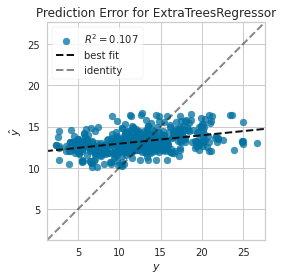

In [ ]:
plot_model(tuned_xgboost, plot = 'error')
# With clustering and sqrt normalizations r2 = 0.107

In [ ]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3203,10.6056,3.2566,-0.1393,0.3927,0.4724
1,2.0495,7.0807,2.6610,0.3508,0.3234,0.3232
2,1.9698,7.0209,2.6497,0.3589,0.3284,0.3517
3,3.4266,22.3838,4.7312,0.3388,0.3762,0.3282
4,3.5342,24.3345,4.9330,-0.0980,0.4972,0.6874
5,2.2967,10.7511,3.2789,0.5377,0.2405,0.2027
6,1.7160,6.2027,2.4905,0.6874,0.1653,0.1295
7,2.6375,11.6965,3.4200,-0.1793,0.2352,0.1933
8,4.0773,26.6147,5.1589,0.0804,0.3415,0.3174


In [ ]:
tuned_catboost  = tune_model(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0421,14.4186,3.7972,-0.5489,0.4812,0.6565
1,2.1976,7.9289,2.8158,0.2730,0.3376,0.3544
2,2.1576,8.3378,2.8875,0.2387,0.3538,0.3842
3,3.9942,26.2151,5.1201,0.2256,0.4050,0.3967
4,3.4019,21.5104,4.6379,0.0295,0.4865,0.6669
5,2.9389,14.3065,3.7824,0.3848,0.2966,0.2893
6,2.3465,10.6523,3.2638,0.4632,0.2348,0.1948
7,2.2728,9.0688,3.0114,0.0856,0.2054,0.1714
8,4.7276,31.2363,5.5889,-0.0792,0.3800,0.3896


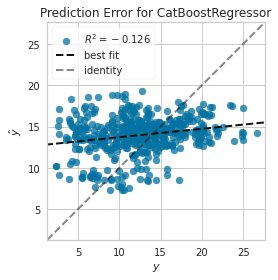

In [ ]:
plot_model(tuned_catboost, plot = 'error')

## Pycaret model search with clustering alone

In [ ]:

train_cluster_data = pd.concat([X_train_cluster_df, y_train], axis=1)
test_cluster_data = pd.concat([X_test_cluster_df, y_test], axis=1)

In [ ]:
from pycaret.regression import *
#We already have an imputed and scaled train and test, we do not want to preprocess
water_depth_cluster_exp = setup(train_cluster_data
                        , target='GSE_GWE',
                        train_size=1.0,
                        test_data= test_cluster_data,
                        preprocess=False, session_id=RANDOM_SEED,
                       log_experiment=True, experiment_name="water_depth_cluster_sqrt")

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 81)"
3,Missing Values,False
4,Numeric Features,80
5,Categorical Features,0
6,Transformed Train Set,"(3346, 80)"
7,Transformed Test Set,"(478, 80)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/06/19 19:35:02 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_cluster_1' does not exist. Creating a new experiment.


In [ ]:
%matplotlib inline
#creating a model
lr = create_model('lr')



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,117521.6595,660313827836.1814,812596.9652,-296371606.4055,2.0338,2782.7835
1,49.7033,5636.2169,75.0747,-0.6683,1.0528,1.8735
2,60.6874,5771.3455,75.9694,-0.6004,1.0184,1.6116
3,118.3915,27897.6179,167.0258,-0.1822,1.3791,1.0267
4,96.3616,14601.9060,120.8383,-0.1042,1.1356,4.8862
5,98.4457,17092.4879,130.7382,0.0705,0.8372,1.0898
6,59.5593,6668.4874,81.6608,0.5894,0.7040,0.4035
7,93.7084,14392.1223,119.9672,-0.7740,0.9762,0.4955
8,150.7039,34352.9646,185.3455,-0.2236,0.8912,1.1502


In [ ]:
compare_models() #Time taken > 17m

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,69.7223,10484.3109,96.0398,0.0746,0.7781,1.5207,4.1300
catboost,CatBoost Regressor,70.9224,11039.9908,99.2784,-0.0234,0.7702,1.5307,24.7910
knn,K Neighbors Regressor,72.3932,11593.2802,102.4067,-0.0258,0.7834,1.3373,0.2100
lightgbm,Light Gradient Boosting Machine,72.2066,12071.8128,103.9338,-0.0831,0.7837,1.6282,0.9020
rf,Random Forest Regressor,73.2270,12109.3941,104.5205,-0.1001,0.7888,1.6185,6.8550
gbr,Gradient Boosting Regressor,76.1096,12004.5654,104.4788,-0.1496,0.8053,1.6578,2.7400
xgboost,Extreme Gradient Boosting,75.6711,12580.2174,105.4749,-0.1697,0.7990,1.5544,2.9430
par,Passive Aggressive Regressor,82.6917,14192.3800,111.3021,-0.1929,0.8594,1.3595,0.0980
huber,Huber Regressor,82.2711,14648.4768,112.7254,-0.2440,0.8933,1.4190,0.2120
ridge,Ridge Regression,85.2479,14124.6868,112.2101,-0.2538,0.9030,1.6377,0.0320


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.8939,5001.3458,70.7202,-1.2448,1.1751,3.0442
1,30.7736,1573.3535,39.6655,0.5343,0.6821,1.1025
2,43.9926,2870.7455,53.5793,0.2039,0.8703,1.6871
3,94.1808,19251.4637,138.7496,0.1842,0.9652,1.1274
4,81.6478,12129.7407,110.1351,0.0828,1.1078,4.9459
5,70.4018,12583.2866,112.1752,0.3157,0.6488,0.7382
6,52.1317,6113.6455,78.1898,0.6235,0.4246,0.3830
7,69.4657,8826.0057,93.9468,-0.0879,0.4521,0.4159
8,125.6503,26245.9812,162.0061,0.0652,0.7508,0.8789


In [ ]:
tuned_et  = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63.1174,5563.2368,74.5871,-1.4970,1.3084,3.7380
1,40.7350,2522.7796,50.2273,0.2533,0.8235,1.3598
2,57.1878,4459.1094,66.7766,-0.2365,1.0203,2.1332
3,110.4627,22292.7618,149.3076,0.0553,0.9754,1.4477
4,80.2089,9761.7126,98.8014,0.2618,1.0313,3.6987
5,88.4695,15779.9712,125.6184,0.1419,0.7241,0.8260
6,82.2057,14105.3879,118.7661,0.1314,0.5858,0.5100
7,71.8424,8924.4392,94.4692,-0.1001,0.4530,0.3257
8,144.9801,33482.7577,182.9829,-0.1926,0.8467,0.9799


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


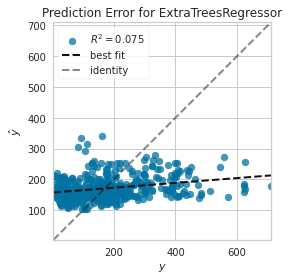

In [ ]:
plot_model(tuned_et, plot = 'error')

## Creating PyCaret experiment for data without cluster label

In [ ]:
train_data = pd.concat([X_train_impute_df, y_train_sqrt], axis=1)
test_data = pd.concat([X_test_impute_df, y_test_sqrt], axis=1)


In [ ]:
from pycaret.regression import *

# We already have an imputed and scaled train and test, we do not want to preprocess
water_depth_normalized_exp = setup(
    train_data,
    target="GSE_GWE",
    train_size=1.0,
    test_data=test_data,
    preprocess=False,
    session_id=RANDOM_SEED,
    log_experiment=True,
    experiment_name="water_depth_normalized",
)


,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,79
5,Categorical Features,0
6,Transformed Train Set,"(3346, 79)"
7,Transformed Test Set,"(478, 79)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [ ]:
%matplotlib inline
#creating a model
lr = create_model('lr')



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.8061,12.5644,3.5446,-0.3497,0.4064,0.5169
1,2.2228,9.5528,3.0908,0.1241,0.3526,0.3700
2,2.7208,11.4746,3.3874,-0.0477,0.4571,0.4594
3,4.6904,40.4606,6.3609,-0.1952,0.5258,0.3944
4,3.7690,23.4119,4.8386,-0.0563,0.4676,0.5972
5,3.6682,21.3679,4.6225,0.0811,0.3693,0.3603
6,2.2195,8.3225,2.8849,0.5806,0.2198,0.1770
7,3.5460,20.7999,4.5607,-1.0972,0.3504,0.2447
8,5.0619,37.6665,6.1373,-0.3014,0.5019,0.4232


In [ ]:
compare_models() #Time taken > 17m

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,2.7132,14.4300,3.6775,0.1960,0.3239,0.3323,19.6000
et,Extra Trees Regressor,2.7354,14.6185,3.6898,0.1834,0.3325,0.3435,3.3320
knn,K Neighbors Regressor,2.9189,16.4794,3.9693,0.0834,0.3520,0.3435,0.1340
rf,Random Forest Regressor,2.8537,15.7693,3.8818,0.0827,0.3414,0.3463,5.7220
lightgbm,Light Gradient Boosting Machine,2.8506,16.5165,3.9327,0.0711,0.3416,0.3490,0.5740
gbr,Gradient Boosting Regressor,2.9788,16.6117,3.9657,0.0645,0.3495,0.3658,1.6810
xgboost,Extreme Gradient Boosting,2.9394,16.7975,3.9805,0.0353,0.3559,0.3599,1.7970
ada,AdaBoost Regressor,3.4133,18.6216,4.2111,-0.0462,0.3774,0.4249,0.5290
ridge,Ridge Regression,3.3423,20.0275,4.3254,-0.1025,0.3807,0.3839,0.0200
br,Bayesian Ridge,3.3806,20.7990,4.4047,-0.1549,0.3936,0.3817,0.0480


In [ ]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3245,10.6211,3.2590,-0.1409,0.3913,0.4716
1,1.8639,6.2618,2.5024,0.4259,0.3096,0.3050
2,2.0687,7.6844,2.7721,0.2983,0.3366,0.3629
3,3.4789,22.7497,4.7697,0.3280,0.3820,0.3354
4,3.6655,25.5265,5.0524,-0.1517,0.5053,0.7088
5,2.3117,10.9056,3.3024,0.5310,0.2417,0.2012
6,1.7594,6.9580,2.6378,0.6494,0.1756,0.1320
7,2.5672,11.2501,3.3541,-0.1343,0.2284,0.1899
8,4.1028,26.6035,5.1579,0.0808,0.3433,0.3182


In [ ]:
tuned_catboost  = tune_model(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,65.8685,5821.9516,76.3017,-1.6131,1.3439,3.8286
1,41.1770,2422.3424,49.2173,0.2830,0.8510,1.4975
2,58.2190,4772.3281,69.0820,-0.3234,1.0675,2.2995
3,120.0881,25542.1140,159.8190,-0.0824,1.0346,1.5344
4,81.4949,11210.6813,105.8805,0.1522,1.0396,3.4871
5,88.3400,15814.7677,125.7568,0.1400,0.7301,0.8500
6,80.1744,13682.3834,116.9717,0.1575,0.5901,0.5309
7,78.5067,9748.8373,98.7362,-0.2017,0.4742,0.3573
8,148.1815,35467.8366,188.3291,-0.2633,0.8458,0.9400


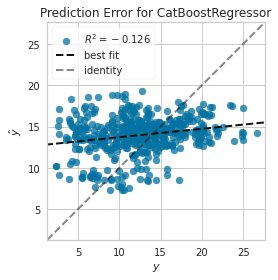

In [ ]:
plot_model(tuned_catboost, plot = 'error')

## Drop features?


In [ ]:
[col for col in X_train_impute_df if not (col.startswith('SOIL') or col.startswith('VEGETATION') or col.startswith('CROP'))]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>